# Modèles de Diffusion pour la Génération d'Images

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer l'architecture révolutionnaire des **Modèles de Diffusion** pour la génération d'images :

1. **Les Autoencodeurs Variationnels (VAE)** - L'approche traditionnelle
2. **L'architecture des Modèles de Diffusion** - La révolution probabiliste
3. **Le processus de débruitage** - Comprendre comment ça fonctionne
4. **La génération d'images** - Application pratique

Nous utiliserons le dataset **Fashion-MNIST** pour entraîner nos modèles à générer des images de vêtements.

## Pourquoi les Modèles de Diffusion ?

Les Modèles de Diffusion ont révolutionné la génération d'images depuis 2020 :
- Qualité d'image supérieure aux GANs et VAEs
- Entraînement stable (contrairement aux GANs)
- Diversité des images générées
- Base de Stable Diffusion, DALL-E 2, Imagen, Midjourney
- Architecture flexible et extensible

## 📚 Concepts clés que nous allons explorer

- **Processus Forward** : Comment ajouter progressivement du bruit
- **Processus Reverse** : Comment débruiter progressivement
- **U-Net** : Architecture pour prédire le bruit
- **Timestep Embedding** : Encoder l'étape de diffusion
- **DDPM (Denoising Diffusion Probabilistic Models)** : Le modèle de référence
- **Sampling** : Techniques pour générer de nouvelles images

## 1. Imports et Configuration

In [1]:
# Bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks, optimizers
from keras.datasets import fashion_mnist

# Utilitaires
import time
from tqdm import tqdm

# Configuration GPU pour économiser la mémoire
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Activer la croissance dynamique de la mémoire
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Croissance dynamique de la mémoire GPU activée")
        print(f"✅ GPU disponible: {gpus}")
    except RuntimeError as e:
        print(f"⚠️ Erreur configuration GPU: {e}")

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Seed pour reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

# Optimisations mémoire GPU (décommentez si nécessaire)
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# print("✅ Mixed precision activé pour économiser la mémoire")

print("✅ Imports réussis !")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

2025-11-06 18:05:08.940691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 18:05:08.998162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 18:05:09.370403: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✅ Croissance dynamique de la mémoire GPU activée
✅ GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Imports réussis !
TensorFlow version: 2.20.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Chargement et Préparation du Dataset : Fashion-MNIST

Pour ce tutoriel, nous allons utiliser **Fashion-MNIST**, un dataset de 70,000 images de vêtements en niveaux de gris (28x28 pixels).

### Catégories du dataset :
- 0: T-shirt/top
- 1: Pantalon
- 2: Pull
- 3: Robe
- 4: Manteau
- 5: Sandale
- 6: Chemise
- 7: Sneaker
- 8: Sac
- 9: Bottine

In [2]:
# Chargement du dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalisation entre -1 et 1 (important pour les modèles de diffusion)
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

# Ajouter une dimension de canal
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"📊 Forme des données d'entraînement: {x_train.shape}")
print(f"📊 Forme des données de test: {x_test.shape}")
print(f"📊 Plage de valeurs: [{x_train.min():.2f}, {x_train.max():.2f}]")

# Noms des classes
class_names = ['T-shirt/top', 'Pantalon', 'Pull', 'Robe', 'Manteau',
               'Sandale', 'Chemise', 'Sneaker', 'Sac', 'Bottine']

📊 Forme des données d'entraînement: (60000, 28, 28, 1)
📊 Forme des données de test: (10000, 28, 28, 1)
📊 Plage de valeurs: [-1.00, 1.00]


### 2.1 Visualisation du Dataset

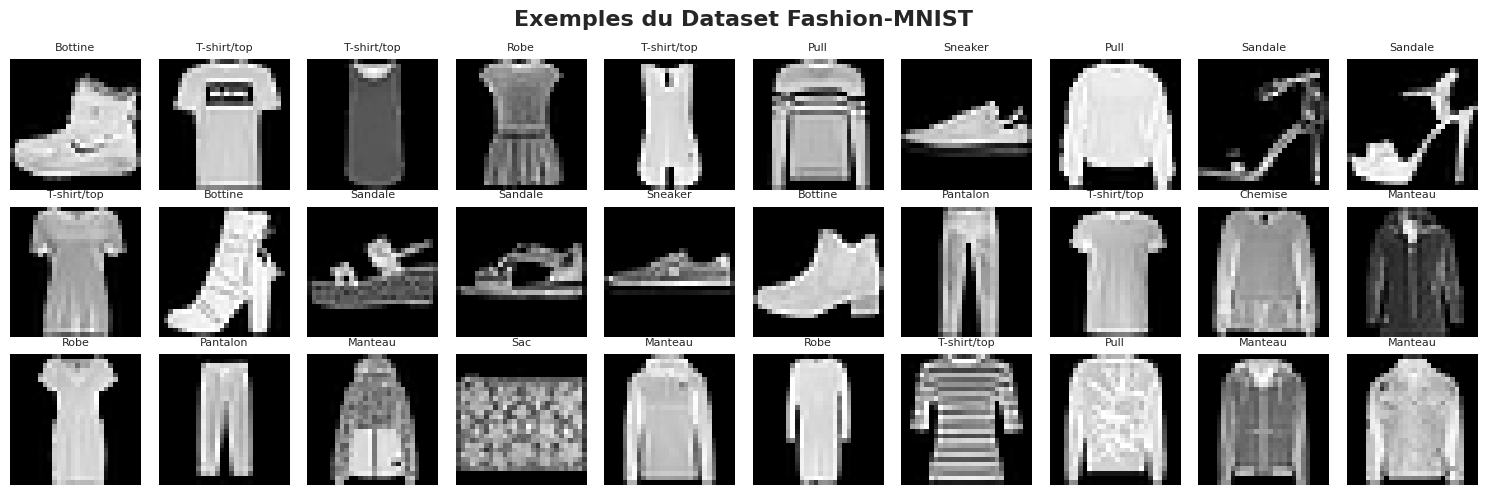


📈 Distribution des classes:
  T-shirt/top    :  6000 images
  Pantalon       :  6000 images
  Pull           :  6000 images
  Robe           :  6000 images
  Manteau        :  6000 images
  Sandale        :  6000 images
  Chemise        :  6000 images
  Sneaker        :  6000 images
  Sac            :  6000 images
  Bottine        :  6000 images


In [3]:
# Visualisation d'exemples
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
fig.suptitle('Exemples du Dataset Fashion-MNIST', fontsize=16, fontweight='bold')

for i in range(30):
    ax = axes[i // 10, i % 10]
    # Dénormaliser pour l'affichage
    img = (x_train[i].squeeze() + 1) * 127.5
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{class_names[y_train[i]]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n📈 Distribution des classes:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {class_names[cls]:15s}: {count:5d} images")

## 3. Modèle Baseline : VAE (Approche Traditionnelle)

Avant de plonger dans les Modèles de Diffusion, créons un **Variational Autoencoder (VAE)** comme référence.

### 3.1 Architecture du VAE

Le VAE se compose de :
- **Encoder** : Compresse l'image en une distribution latente (μ, σ)
- **Reparameterization Trick** : z = μ + σ × ε où ε ~ N(0,1)
- **Decoder** : Reconstruit l'image à partir de z

In [4]:
class Sampling(layers.Layer):
    """Reparameterization trick pour le VAE."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def creer_encoder_vae(latent_dim=128):
    """Crée l'encoder du VAE."""
    inputs = layers.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder


def creer_decoder_vae(latent_dim=128):
    """Crée le decoder du VAE."""
    latent_inputs = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="tanh", padding="same")(x)
    
    decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder


class VAE(models.Model):
    """Variational Autoencoder complet."""
    
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        """Forward pass du VAE."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
            )
            
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# Création du VAE
latent_dim = 128
encoder_vae = creer_encoder_vae(latent_dim)
decoder_vae = creer_decoder_vae(latent_dim)
vae = VAE(encoder_vae, decoder_vae)

vae.compile(optimizer=optimizers.Adam(learning_rate=0.001), run_eagerly=True)

print("\n📋 Architecture de l'Encoder:")
encoder_vae.summary()

print("\n📋 Architecture du Decoder:")
decoder_vae.summary()

I0000 00:00:1762448710.936954  291529 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9



📋 Architecture de l'Encoder:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    803,072 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 887,680 (3.39 MB)

 Trainable params: 887,680 (3.39 MB)

 Non-trainable params: 0 (0.00 B)


📋 Architecture du Decoder:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │       404,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,225 (1.76 MB)

 Trainable params: 460,225 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Entraînement du VAE

🚀 Début de l'entraînement du VAE...

Epoch 1/20


2025-11-06 18:05:11.823561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - kl_loss: 18.5347 - loss: 150.0979 - reconstruction_loss: 131.5632
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - kl_loss: 20.5520 - loss: 91.2957 - reconstruction_loss: 70.7438
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.5599 - loss: 80.1665 - reconstruction_loss: 60.6067
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.2333 - loss: 74.2389 - reconstruction_loss: 55.0056
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 19.1838 - loss: 71.3029 - reconstruction_loss: 52.1191

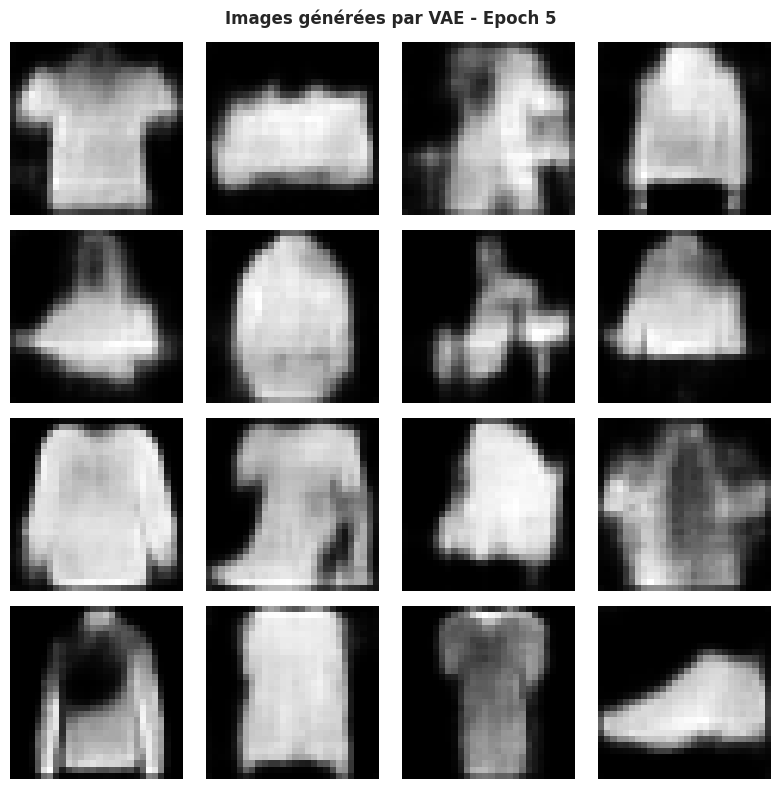

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - kl_loss: 19.1297 - loss: 70.4577 - reconstruction_loss: 51.3280
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - kl_loss: 19.1037 - loss: 68.1407 - reconstruction_loss: 49.0370
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.0933 - loss: 66.6036 - reconstruction_loss: 47.5103
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - kl_loss: 19.1221 - loss: 65.5698 - reconstruction_loss: 46.4478
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - kl_loss: 19.1560 - loss: 64.7507 - reconstruction_loss: 45.5947
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - kl_loss: 19.2095 - loss: 64.2571 - reconstruction_loss: 45.0476

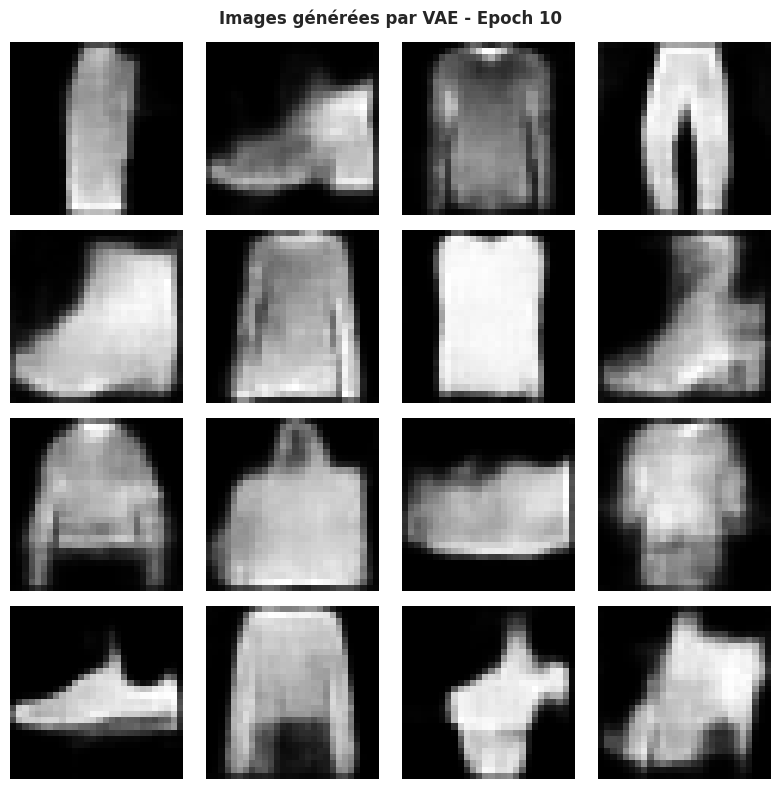

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - kl_loss: 19.1686 - loss: 64.0331 - reconstruction_loss: 44.8646
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - kl_loss: 19.2045 - loss: 63.4842 - reconstruction_loss: 44.2797
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.2107 - loss: 62.9921 - reconstruction_loss: 43.7813
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - kl_loss: 19.1973 - loss: 62.5542 - reconstruction_loss: 43.3569
Epoch 14/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.2467 - loss: 62.2742 - reconstruction_loss: 43.0276
Epoch 15/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 19.2833 - loss: 62.1843 - reconstruction_loss: 42.9010

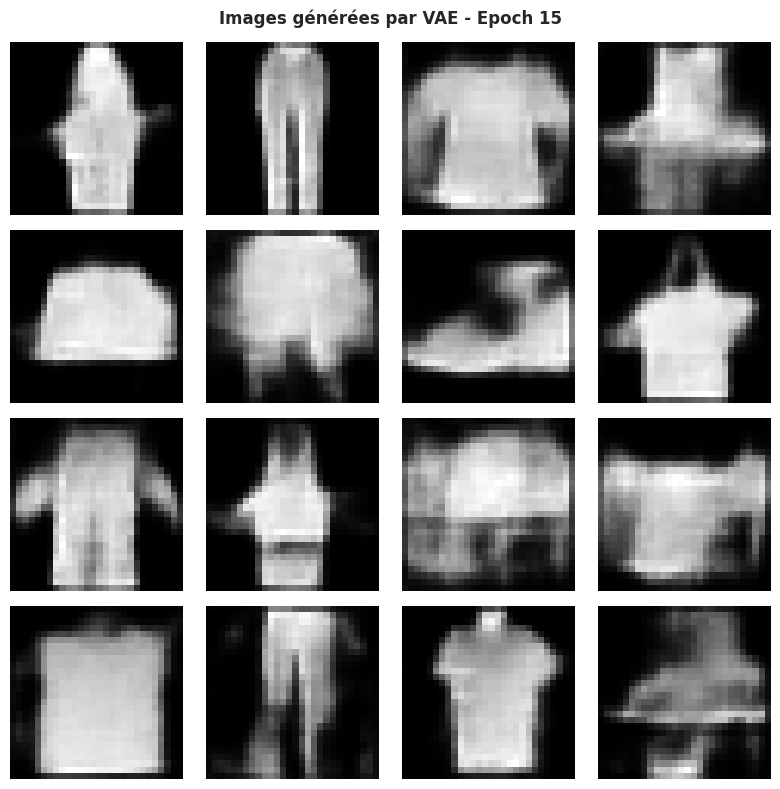

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.2489 - loss: 61.9522 - reconstruction_loss: 42.7033
Epoch 16/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.2288 - loss: 61.5163 - reconstruction_loss: 42.2876
Epoch 17/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - kl_loss: 19.2320 - loss: 61.2950 - reconstruction_loss: 42.0630
Epoch 18/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.2523 - loss: 61.0626 - reconstruction_loss: 41.8103
Epoch 19/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - kl_loss: 19.2982 - loss: 60.8273 - reconstruction_loss: 41.5291
Epoch 20/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 19.3095 - loss: 60.7337 - reconstruction_loss: 41.4242

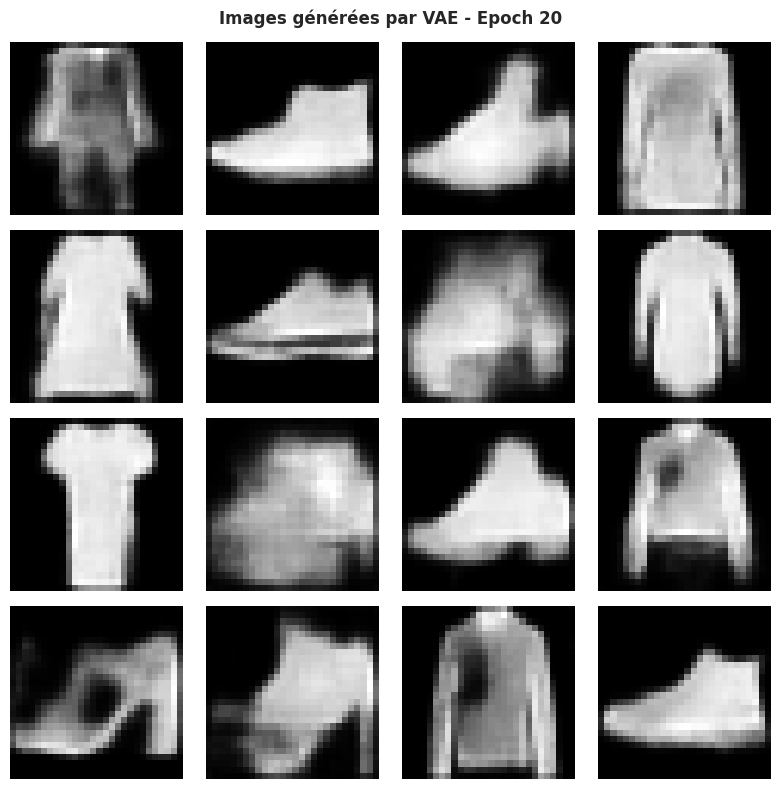

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - kl_loss: 19.2705 - loss: 60.5780 - reconstruction_loss: 41.3075

✅ Entraînement du VAE terminé !


In [5]:
# Callback pour visualiser la progression
class VAEProgressCallback(callbacks.Callback):
    def __init__(self, test_images):
        super().__init__()
        self.test_images = test_images
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            # Générer des images
            z_sample = tf.random.normal(shape=(16, latent_dim))
            generated_images = self.model.decoder(z_sample)
            
            fig, axes = plt.subplots(4, 4, figsize=(8, 8))
            fig.suptitle(f'Images générées par VAE - Epoch {epoch + 1}', fontweight='bold')
            
            for i, ax in enumerate(axes.flat):
                img = (generated_images[i].numpy().squeeze() + 1) * 127.5
                ax.imshow(img, cmap='gray')
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()


# Entraînement du VAE
print("🚀 Début de l'entraînement du VAE...\n")

history_vae = vae.fit(
    x_train,
    epochs=20,
    batch_size=128,
    callbacks=[VAEProgressCallback(x_test[:16])],
    verbose=1
)

print("\n✅ Entraînement du VAE terminé !")

### 3.3 Génération d'images avec le VAE

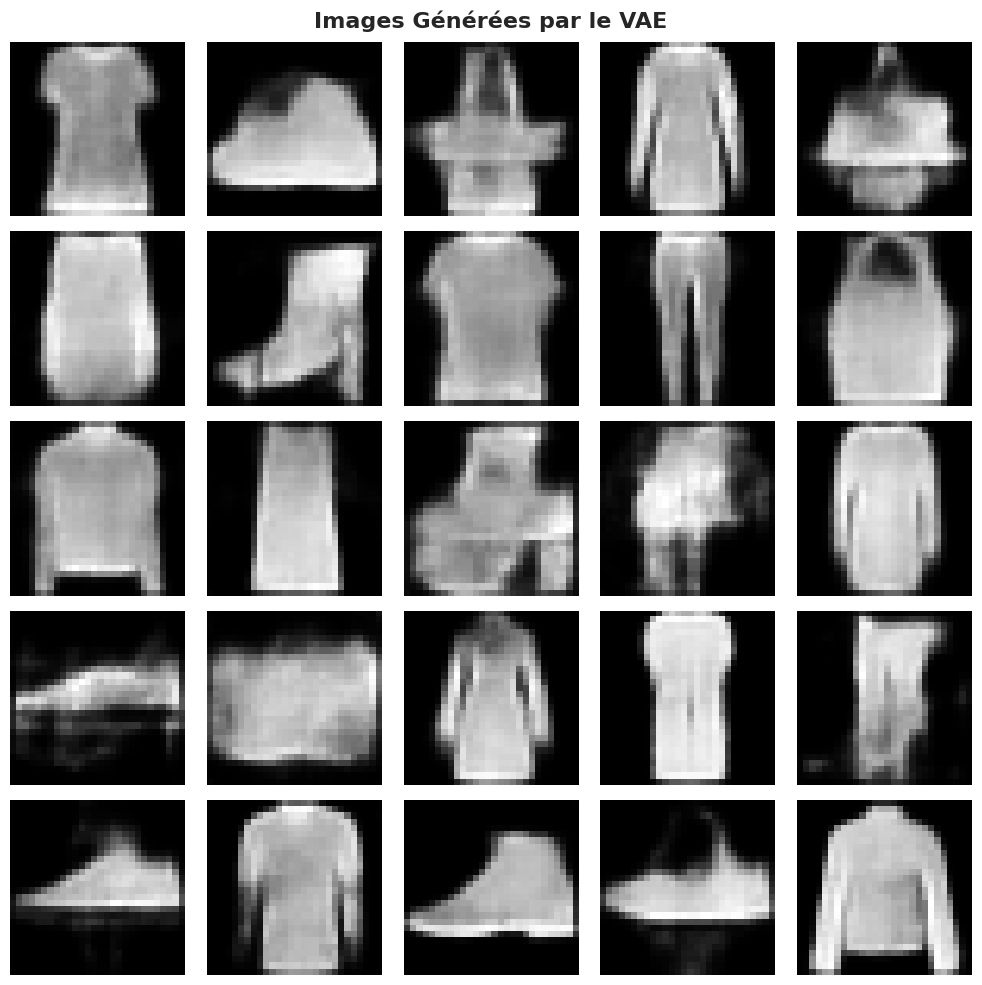

In [6]:
# Génération de nouvelles images
def generer_images_vae(decoder, n_images=16, latent_dim=128):
    """Génère des images à partir de vecteurs latents aléatoires."""
    z_sample = tf.random.normal(shape=(n_images, latent_dim))
    generated_images = decoder(z_sample)
    return generated_images.numpy()


# Générer et afficher
generated_vae = generer_images_vae(decoder_vae, n_images=25)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Images Générées par le VAE', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    img = (generated_vae[i].squeeze() + 1) * 127.5
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4. L'Architecture des Modèles de Diffusion

### 4.1 Les concepts fondamentaux

Les Modèles de Diffusion reposent sur deux processus :

#### 1. **Processus Forward (Diffusion)** : Ajout progressif de bruit
- On part d'une image réelle x₀
- On ajoute progressivement du bruit gaussien en T étapes
- Après T étapes, l'image devient du pur bruit gaussien
- Formule : xₜ = √(ᾱₜ) × x₀ + √(1 - ᾱₜ) × ε, où ε ~ N(0,I)

#### 2. **Processus Reverse (Débruitage)** : Suppression progressive du bruit
- On part de pur bruit gaussien xₜ
- Un réseau de neurones prédit le bruit à chaque étape
- On retire progressivement le bruit en T étapes
- On obtient une nouvelle image x₀

#### 3. **U-Net** : Architecture pour prédire le bruit
- Réseau en forme de U avec connexions skip
- Prend en entrée : l'image bruitée + l'étape temporelle t
- Sort : le bruit prédit ε̂

#### 4. **Timestep Embedding**
- Encode l'étape t de la diffusion
- Utilise des embeddings sinusoïdaux (comme dans les Transformers)
- Permet au réseau de "savoir" où il en est dans le processus

### 4.2 Le schedule de bruit (Beta Schedule)

Le schedule contrôle la quantité de bruit ajoutée à chaque étape :
- **Linear schedule** : β augmente linéairement
- **Cosine schedule** : progression plus douce

### 4.3 Implémentation des composants

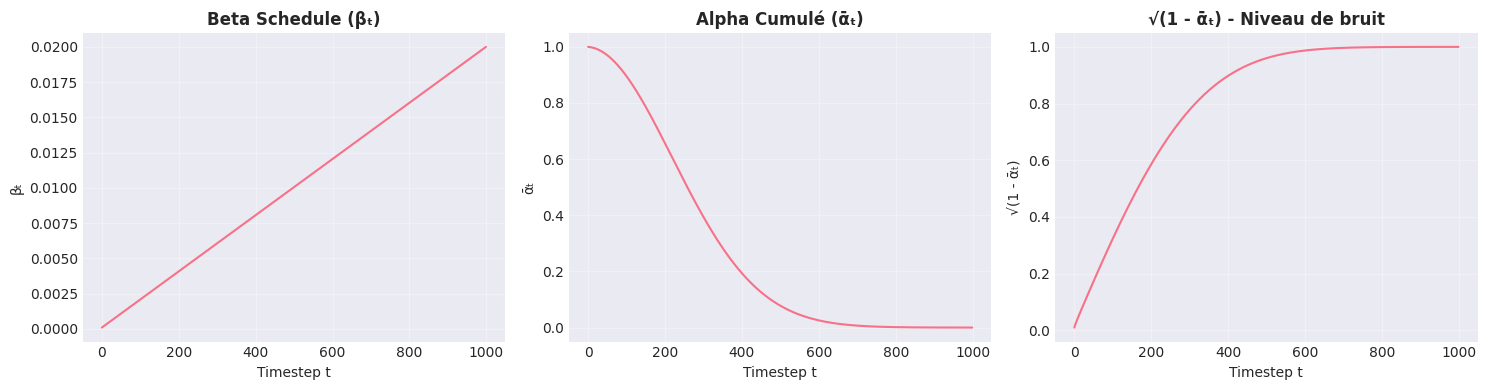

✅ Schedule de diffusion créé avec 1000 timesteps


In [7]:
# Hyperparamètres du modèle de diffusion
IMG_SIZE = 28
IMG_CHANNELS = 1
TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02


def get_beta_schedule(timesteps, schedule_type="linear"):
    """
    Crée le schedule de bruit (beta).
    
    Args:
        timesteps: Nombre d'étapes de diffusion
        schedule_type: 'linear' ou 'cosine'
    
    Returns:
        betas: Schedule de bruit
    """
    if schedule_type == "linear":
        betas = np.linspace(BETA_START, BETA_END, timesteps, dtype=np.float32)
    elif schedule_type == "cosine":
        steps = timesteps + 1
        x = np.linspace(0, timesteps, steps, dtype=np.float32)
        alphas_cumprod = np.cos(((x / timesteps) + 0.008) / 1.008 * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        betas = np.clip(betas, 0.0001, 0.9999)
    
    return betas


def prepare_diffusion_params(betas):
    """
    Pré-calcule tous les paramètres nécessaires pour la diffusion.
    
    Returns:
        Dictionnaire contenant tous les paramètres
    """
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas, axis=0)
    alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
    
    sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
    sqrt_recip_alphas = np.sqrt(1.0 / alphas)
    
    # Paramètres pour le processus reverse
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    
    return {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'posterior_variance': posterior_variance
    }


# Créer le schedule
betas = get_beta_schedule(TIMESTEPS, schedule_type="linear")
diffusion_params = prepare_diffusion_params(betas)

# Visualisation du schedule
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(diffusion_params['betas'])
axes[0].set_title('Beta Schedule (βₜ)', fontweight='bold')
axes[0].set_xlabel('Timestep t')
axes[0].set_ylabel('βₜ')
axes[0].grid(True, alpha=0.3)

axes[1].plot(diffusion_params['alphas_cumprod'])
axes[1].set_title('Alpha Cumulé (ᾱₜ)', fontweight='bold')
axes[1].set_xlabel('Timestep t')
axes[1].set_ylabel('ᾱₜ')
axes[1].grid(True, alpha=0.3)

axes[2].plot(diffusion_params['sqrt_one_minus_alphas_cumprod'])
axes[2].set_title('√(1 - ᾱₜ) - Niveau de bruit', fontweight='bold')
axes[2].set_xlabel('Timestep t')
axes[2].set_ylabel('√(1 - ᾱₜ)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Schedule de diffusion créé avec {TIMESTEPS} timesteps")

### 4.4 Visualisation du Processus Forward (Ajout de bruit)

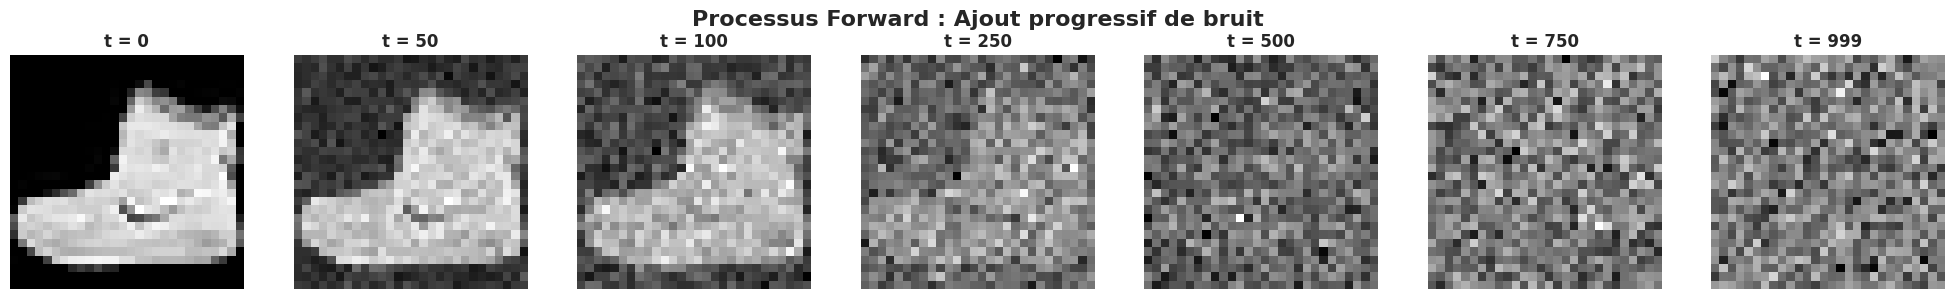


💡 Observation : L'image devient progressivement du pur bruit gaussien !


In [8]:
def forward_diffusion(x0, t, diffusion_params):
    """
    Ajoute du bruit à une image selon le timestep t.
    
    Args:
        x0: Image originale
        t: Timestep (entre 0 et TIMESTEPS-1)
        diffusion_params: Paramètres de diffusion
    
    Returns:
        xt: Image bruitée
        noise: Bruit ajouté
    """
    noise = np.random.randn(*x0.shape).astype(np.float32)
    
    sqrt_alpha_cumprod_t = diffusion_params['sqrt_alphas_cumprod'][t]
    sqrt_one_minus_alpha_cumprod_t = diffusion_params['sqrt_one_minus_alphas_cumprod'][t]
    
    # xₜ = √(ᾱₜ) × x₀ + √(1 - ᾱₜ) × ε
    xt = sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise
    
    return xt, noise


# Visualiser le processus forward sur une image
test_img = x_train[0]
timesteps_to_show = [0, 50, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 3))
fig.suptitle('Processus Forward : Ajout progressif de bruit', fontsize=16, fontweight='bold')

for i, t in enumerate(timesteps_to_show):
    if t == 0:
        noisy_img = test_img
    else:
        noisy_img, _ = forward_diffusion(test_img, t, diffusion_params)
    
    img_display = (noisy_img.squeeze() + 1) * 127.5
    axes[i].imshow(img_display, cmap='gray')
    axes[i].set_title(f't = {t}', fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Observation : L'image devient progressivement du pur bruit gaussien !")

## 5. Architecture U-Net pour le Débruitage

Le U-Net est l'architecture clé des modèles de diffusion. Il prédit le bruit à chaque étape.

### Composants du U-Net :
1. **Downsampling** : Encoder qui réduit la résolution
2. **Skip Connections** : Connexions directes entre encoder et decoder
3. **Upsampling** : Decoder qui augmente la résolution
4. **Time Embedding** : Injection de l'information temporelle

In [9]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Crée des embeddings sinusoïdaux pour les timesteps.
    Similaire au positional encoding des Transformers.
    
    Args:
        timesteps: Tensor de shape (batch_size,) contenant les timesteps
        embedding_dim: Dimension de l'embedding
    
    Returns:
        Tensor de shape (batch_size, embedding_dim)
    """
    half_dim = embedding_dim // 2
    emb = tf.math.log(10000.0) / (half_dim - 1)
    emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
    emb = tf.cast(timesteps, dtype=tf.float32)[:, None] * emb[None, :]
    emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
    return emb


class TimeEmbedding(layers.Layer):
    """Couche d'embedding temporel."""
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mlp = keras.Sequential([
            layers.Dense(dim * 4, activation="swish"),
            layers.Dense(dim * 4)
        ])
    
    def call(self, timesteps):
        # Créer l'embedding sinusoïdal
        emb = get_timestep_embedding(timesteps, self.dim)
        return self.mlp(emb)


def ResidualBlock(x, filters, time_emb=None):
    """
    Bloc résiduel avec injection de time embedding.
    """
    # Première convolution
    h = layers.Conv2D(filters, 3, padding="same")(x)
    h = layers.GroupNormalization(groups=8)(h)
    
    # Injection du time embedding
    if time_emb is not None:
        time_emb_proj = layers.Dense(filters)(time_emb)
        time_emb_proj = layers.Reshape((1, 1, filters))(time_emb_proj)
        h = h + time_emb_proj
    
    h = layers.Activation("swish")(h)
    
    # Deuxième convolution
    h = layers.Conv2D(filters, 3, padding="same")(h)
    h = layers.GroupNormalization(groups=8)(h)
    
    # Skip connection
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1)(x)
    
    return layers.Add()([x, h])


def DownBlock(x, filters, time_emb):
    """Bloc de downsampling."""
    x = ResidualBlock(x, filters, time_emb)
    x = ResidualBlock(x, filters, time_emb)
    skip = x
    x = layers.AveragePooling2D(2)(x)
    return x, skip


def UpBlock(x, skip, filters, time_emb):
    """Bloc de upsampling avec skip connection."""
    x = layers.UpSampling2D(2, interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skip])
    x = ResidualBlock(x, filters, time_emb)
    x = ResidualBlock(x, filters, time_emb)
    return x


def creer_unet(img_size=28, img_channels=1, base_filters=64, time_emb_dim=128):
    """
    Crée le U-Net pour prédire le bruit.
    
    Architecture:
        - Input: Image bruitée + Timestep
        - Output: Bruit prédit
    """
    # Inputs
    img_input = layers.Input(shape=(img_size, img_size, img_channels), name="image")
    time_input = layers.Input(shape=(), dtype=tf.int32, name="timestep")
    
    # Time embedding
    time_emb = TimeEmbedding(time_emb_dim)(time_input)
    
    # Première convolution
    x = layers.Conv2D(base_filters, 3, padding="same")(img_input)
    
    # Downsampling path
    x, skip1 = DownBlock(x, base_filters, time_emb)      # 28x28 -> 14x14
    x, skip2 = DownBlock(x, base_filters * 2, time_emb)  # 14x14 -> 7x7
    
    # Bottleneck
    x = ResidualBlock(x, base_filters * 4, time_emb)
    x = ResidualBlock(x, base_filters * 4, time_emb)
    
    # Upsampling path
    x = UpBlock(x, skip2, base_filters * 2, time_emb)  # 7x7 -> 14x14
    x = UpBlock(x, skip1, base_filters, time_emb)      # 14x14 -> 28x28
    
    # Couche de sortie
    output = layers.Conv2D(img_channels, 1, padding="same")(x)
    
    model = models.Model([img_input, time_input], output, name="unet")
    return model


# Créer le U-Net
# Créer le U-Net avec moins de filtres pour économiser la mémoire
unet = creer_unet(IMG_SIZE, IMG_CHANNELS, base_filters=32)

print("📋 Architecture du U-Net:")
unet.summary()

print(f"\n✅ U-Net créé avec {unet.count_params():,} paramètres")

📋 Architecture du U-Net:


Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ timestep            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_embedding      │ (None, 512)       │    328,704 │ timestep[0][0]    │
│ (TimeEmbedding)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │     16,416 │ time_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 28, 28,    │         64 │ conv2d_3[0][0]    │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ group_normalizat… │
│                     │ 32)               │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_4[0][0]    │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28,    │          0 │ conv2d_2[0][0],   │
│                     │ 32)               │            │ group_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      9,248 │ add_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │     16,416 │ time_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_5[0][0]    │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 32)  │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 28, 28,    │          0 │ group_normalizat… │
│                     │ 32)               │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,645,569 (6.28 MB)

 Trainable params: 1,645,569 (6.28 MB)

 Non-trainable params: 0 (0.00 B)


✅ U-Net créé avec 1,645,569 paramètres


## 6. Entraînement du Modèle de Diffusion

### 6.1 Loss Function

La loss est simple : **Mean Squared Error entre le bruit réel et le bruit prédit**

```
L = MSE(ε, ε̂)
```

où :
- ε : bruit réel ajouté
- ε̂ : bruit prédit par le U-Net

In [10]:
class DiffusionModel(models.Model):
    """
    Modèle de diffusion complet (DDPM).
    
    Le modèle apprend à prédire le bruit ajouté à une image.
    """
    
    def __init__(self, unet, diffusion_params, timesteps):
        super().__init__()
        self.unet = unet
        self.timesteps = timesteps
        
        # Convertir tous les paramètres en tensors constants
        self.sqrt_alphas_cumprod = tf.constant(diffusion_params['sqrt_alphas_cumprod'], dtype=tf.float32)
        self.sqrt_one_minus_alphas_cumprod = tf.constant(diffusion_params['sqrt_one_minus_alphas_cumprod'], dtype=tf.float32)
        self.sqrt_recip_alphas = tf.constant(diffusion_params['sqrt_recip_alphas'], dtype=tf.float32)
        self.betas = tf.constant(diffusion_params['betas'], dtype=tf.float32)
        self.posterior_variance = tf.constant(diffusion_params['posterior_variance'], dtype=tf.float32)
        self.alphas_cumprod = tf.constant(diffusion_params['alphas_cumprod'], dtype=tf.float32)
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
    
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, images):
        batch_size = tf.shape(images)[0]
        
        # Échantillonner des timesteps aléatoires
        t = tf.random.uniform(
            shape=(batch_size,),
            minval=0,
            maxval=self.timesteps,
            dtype=tf.int32
        )
        
        # Générer du bruit
        noise = tf.random.normal(shape=tf.shape(images))
        
        # Appliquer le forward diffusion
        sqrt_alpha_cumprod_t = tf.gather(self.sqrt_alphas_cumprod, t)
        sqrt_alpha_cumprod_t = tf.reshape(sqrt_alpha_cumprod_t, (-1, 1, 1, 1))
        
        sqrt_one_minus_alpha_cumprod_t = tf.gather(self.sqrt_one_minus_alphas_cumprod, t)
        sqrt_one_minus_alpha_cumprod_t = tf.reshape(sqrt_one_minus_alpha_cumprod_t, (-1, 1, 1, 1))
        
        noisy_images = sqrt_alpha_cumprod_t * images + sqrt_one_minus_alpha_cumprod_t * noise
        
        with tf.GradientTape() as tape:
            # Prédire le bruit
            noise_pred = self.unet([noisy_images, t], training=True)
            
            # Calculer la loss (MSE entre bruit réel et prédit)
            loss = tf.reduce_mean(tf.square(noise - noise_pred))
        
        # Backpropagation
        gradients = tape.gradient(loss, self.unet.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.unet.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def generate_images(self, num_images=16, show_progress=True):
        """
        Génère de nouvelles images en partant de bruit pur.
        
        Processus:
        1. Commencer avec du bruit pur (t=T)
        2. Pour chaque timestep de T à 0:
            - Prédire le bruit avec le U-Net
            - Débruiter l'image
        3. Retourner l'image finale
        """
        # Partir de bruit pur
        img = tf.random.normal(shape=(num_images, IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
        
        # Processus reverse
        timesteps_range = range(self.timesteps - 1, -1, -1)
        if show_progress:
            timesteps_range = tqdm(timesteps_range, desc="Génération")
        
        for t in timesteps_range:
            t_batch = tf.fill((num_images,), t)
            
            # Prédire le bruit
            noise_pred = self.unet([img, t_batch], training=False)
            
            # Récupérer les paramètres
            sqrt_recip_alphas_t = self.sqrt_recip_alphas[t]
            betas_t = self.betas[t]
            sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t]
            
            # Débruiter
            img = sqrt_recip_alphas_t * (
                img - betas_t / sqrt_one_minus_alphas_cumprod_t * noise_pred
            )
            
            # Ajouter du bruit sauf à la dernière étape
            if t > 0:
                noise = tf.random.normal(shape=tf.shape(img))
                posterior_variance_t = self.posterior_variance[t]
                img = img + tf.sqrt(posterior_variance_t) * noise
        
        return img.numpy()


# Créer le modèle de diffusion
diffusion_model = DiffusionModel(
    unet=unet,
    diffusion_params=diffusion_params,
    timesteps=TIMESTEPS
)

diffusion_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    run_eagerly=True
)

print("✅ Modèle de diffusion créé et compilé !")

✅ Modèle de diffusion créé et compilé !


### 6.2 Callback pour visualiser la progression

In [11]:
class DiffusionProgressCallback(callbacks.Callback):
    """Callback pour visualiser les images générées pendant l'entraînement."""
    
    def __init__(self, generate_every=5):
        super().__init__()
        self.generate_every = generate_every
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.generate_every == 0:
            print(f"\n🎨 Génération d'images à l'epoch {epoch + 1}...")
            
            # Générer 16 images
            generated = self.model.generate_images(num_images=16, show_progress=False)
            
            # Afficher
            fig, axes = plt.subplots(4, 4, figsize=(10, 10))
            fig.suptitle(f'Images générées - Epoch {epoch + 1}', fontsize=16, fontweight='bold')
            
            for i, ax in enumerate(axes.flat):
                img = (generated[i].squeeze() + 1) * 127.5
                img = np.clip(img, 0, 255)
                ax.imshow(img, cmap='gray')
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Loss: {logs['loss']:.4f}")

### 6.3 Entraînement

⚠️ **Note** : L'entraînement d'un modèle de diffusion prend du temps (plusieurs heures sur CPU).

💾 **Optimisations mémoire GPU appliquées** :
- Batch size réduit à **32** (au lieu de 128)
- U-Net avec **32 filtres de base** (au lieu de 64) - modèle ~4x plus petit
- Croissance dynamique de la mémoire GPU activée

Si vous obtenez toujours une erreur **OOM (Out Of Memory)** :
- Réduisez le batch_size à **16** ou **8**
- Réduisez les filtres du U-Net à **24** ou **16**
- Utilisez moins d'epochs pour tester (5-10) 
Pour ce tutoriel, nous utilisons un petit nombre d'epochs. Pour de meilleurs résultats, entraînez pendant 100+ epochs.

🚀 Début de l'entraînement du modèle de diffusion...

⏱️  Ceci peut prendre du temps. Soyez patient !

Epoch 1/40
 38/469 ━━━━━━━━━━━━━━━━━━━━ 2:50 395ms/step - loss: 8.9173

469/469 ━━━━━━━━━━━━━━━━━━━━ 187s 396ms/step - loss: 0.7241
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 182s 388ms/step - loss: 0.1624
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 183s 391ms/step - loss: 0.1367
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 396ms/step - loss: 0.1237
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.1163
🎨 Génération d'images à l'epoch 5...


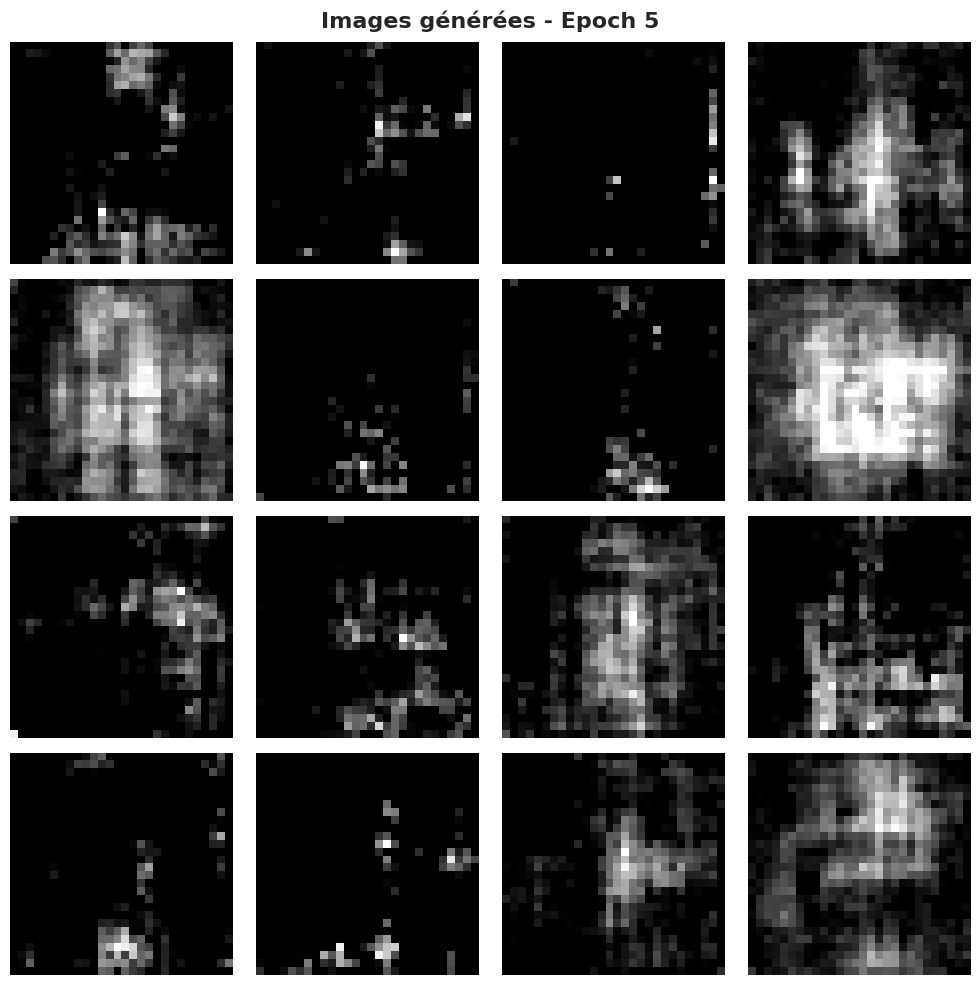

Loss: 0.1150
469/469 ━━━━━━━━━━━━━━━━━━━━ 250s 534ms/step - loss: 0.1150
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 395ms/step - loss: 0.1057
Epoch 7/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - loss: 0.0986
Epoch 8/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 402ms/step - loss: 0.0913
Epoch 9/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - loss: 0.0844
Epoch 10/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.0804
🎨 Génération d'images à l'epoch 10...


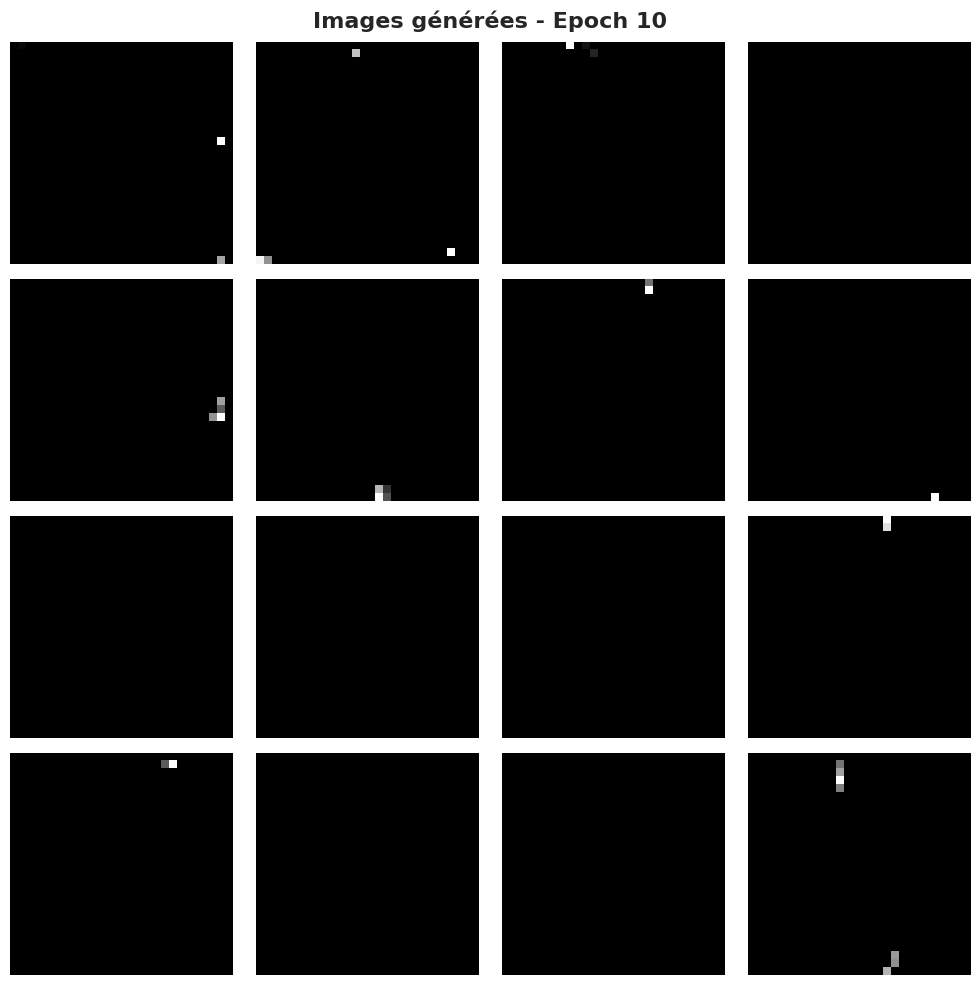

Loss: 0.0800
469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 550ms/step - loss: 0.0800
Epoch 11/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 187s 398ms/step - loss: 0.0768
Epoch 12/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 397ms/step - loss: 0.0729
Epoch 13/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 402ms/step - loss: 0.0698
Epoch 14/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 187s 398ms/step - loss: 0.0689
Epoch 15/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.0668
🎨 Génération d'images à l'epoch 15...


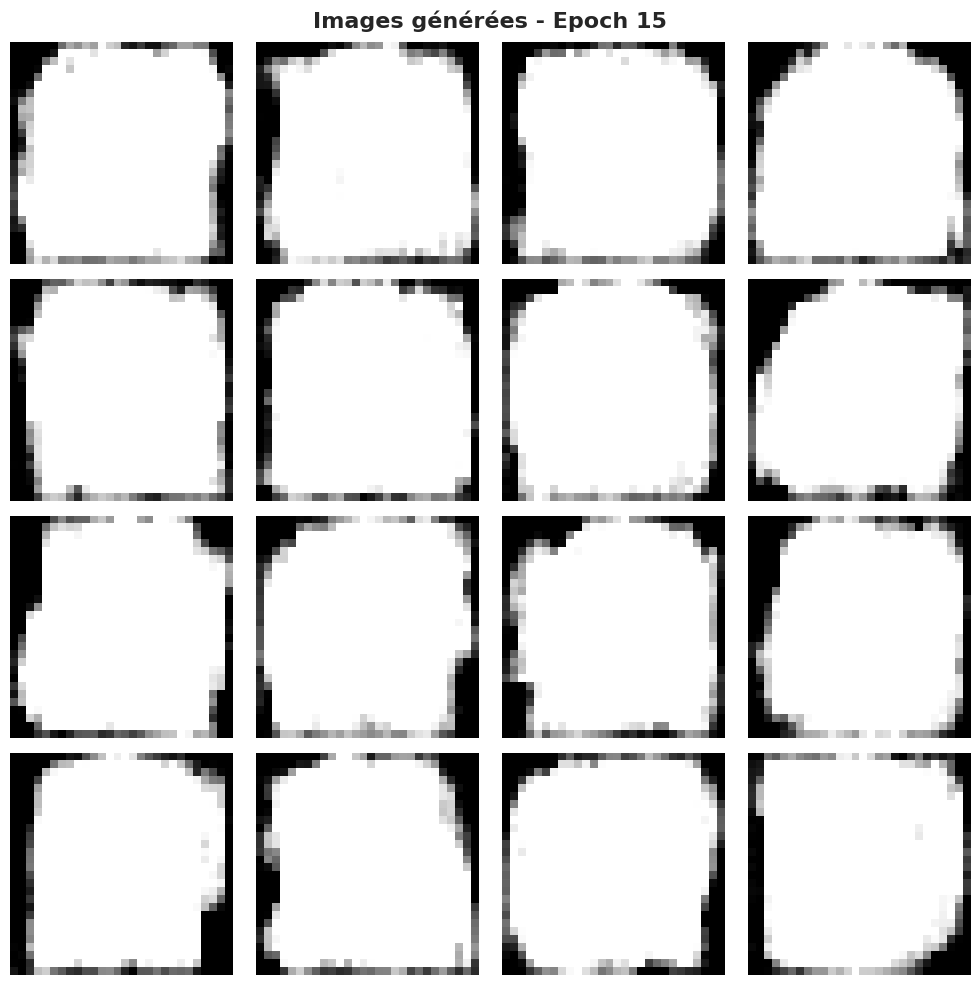

Loss: 0.0666
469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 549ms/step - loss: 0.0666
Epoch 16/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 402ms/step - loss: 0.0643
Epoch 17/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 402ms/step - loss: 0.0624
Epoch 18/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - loss: 0.0617
Epoch 19/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 402ms/step - loss: 0.0594
Epoch 20/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.0590
🎨 Génération d'images à l'epoch 20...


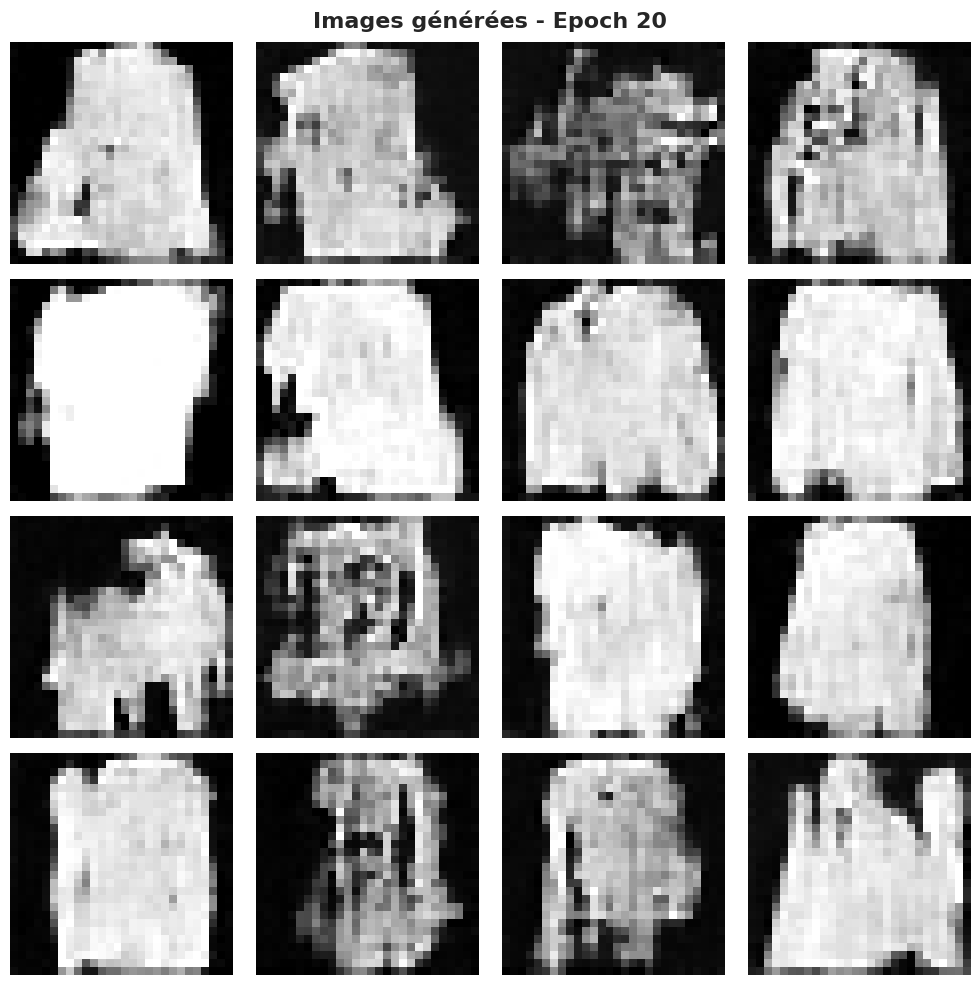

Loss: 0.0589
469/469 ━━━━━━━━━━━━━━━━━━━━ 259s 552ms/step - loss: 0.0589
Epoch 21/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - loss: 0.0587
Epoch 22/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 191s 406ms/step - loss: 0.0564
Epoch 23/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - loss: 0.0555
Epoch 24/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 402ms/step - loss: 0.0550
Epoch 25/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.0544
🎨 Génération d'images à l'epoch 25...


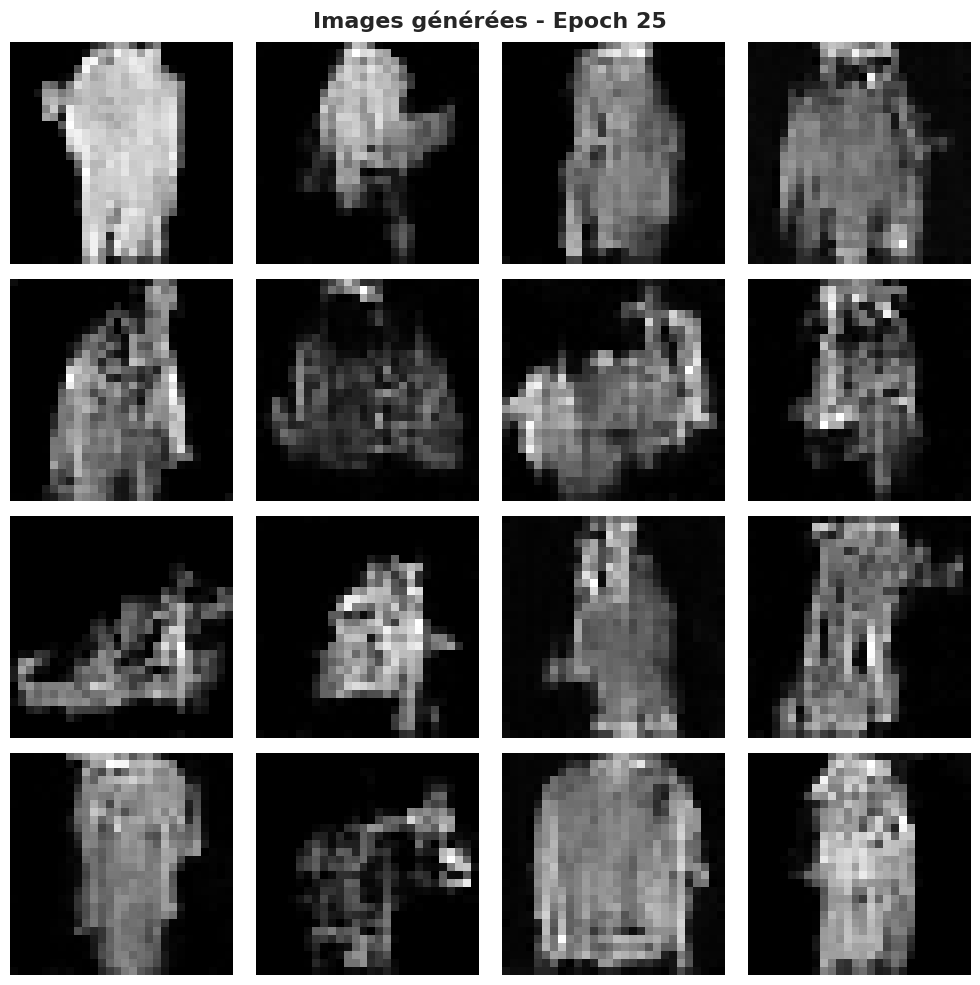

Loss: 0.0541
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 556ms/step - loss: 0.0541
Epoch 26/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 190s 404ms/step - loss: 0.0534
Epoch 27/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 404ms/step - loss: 0.0521
Epoch 28/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 401ms/step - loss: 0.0518
Epoch 29/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 403ms/step - loss: 0.0512
Epoch 30/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.0520
🎨 Génération d'images à l'epoch 30...


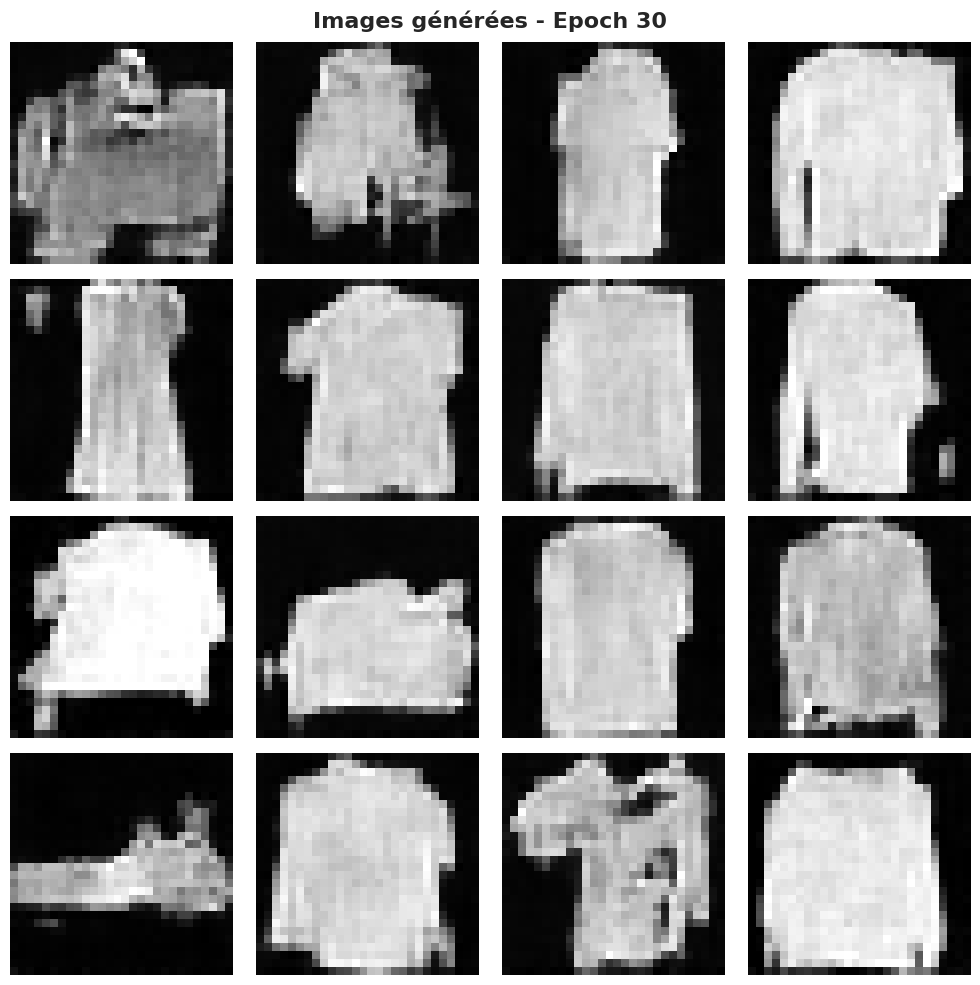

Loss: 0.0506
469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 550ms/step - loss: 0.0506
Epoch 31/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 401ms/step - loss: 0.0499
Epoch 32/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 404ms/step - loss: 0.0501
Epoch 33/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 403ms/step - loss: 0.0489
Epoch 34/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 189s 402ms/step - loss: 0.0484
Epoch 35/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.0478
🎨 Génération d'images à l'epoch 35...


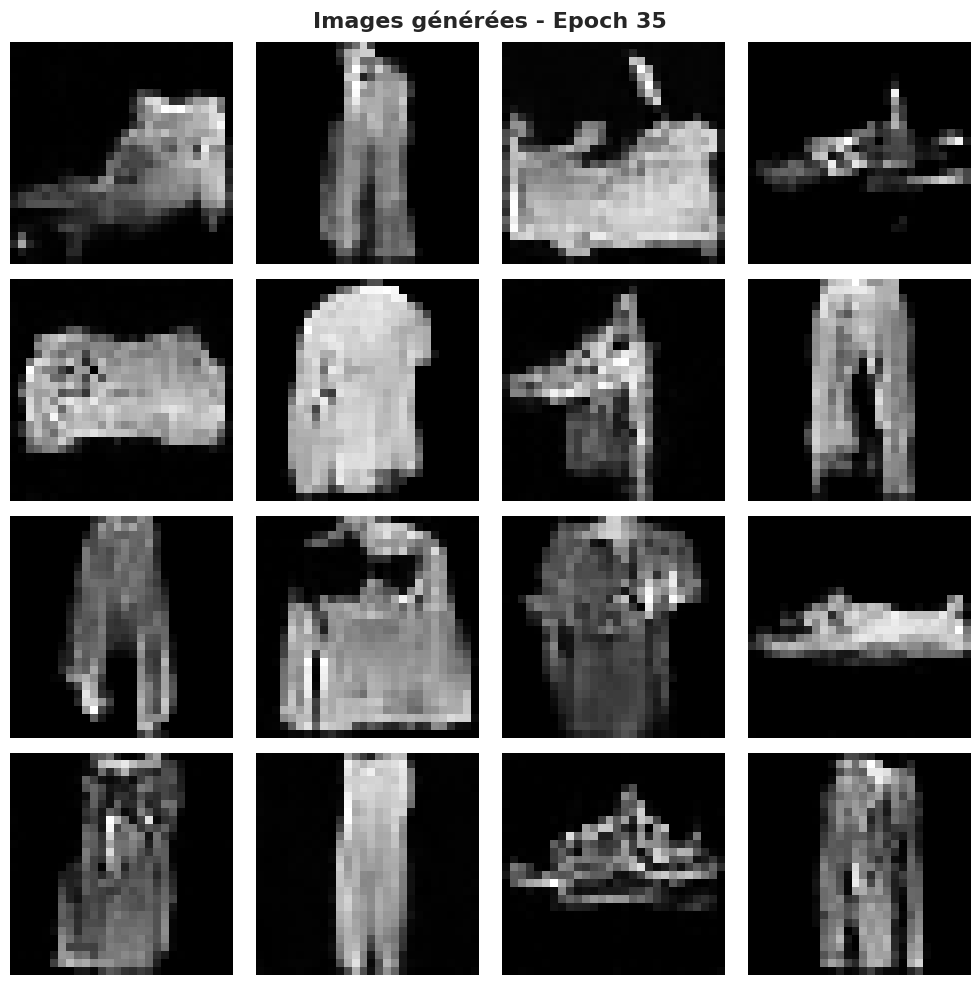

Loss: 0.0481
469/469 ━━━━━━━━━━━━━━━━━━━━ 259s 551ms/step - loss: 0.0481
Epoch 36/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 402ms/step - loss: 0.0474
Epoch 37/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 402ms/step - loss: 0.0478
Epoch 38/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 400ms/step - loss: 0.0468
Epoch 39/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 401ms/step - loss: 0.0465
Epoch 40/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.0465
🎨 Génération d'images à l'epoch 40...


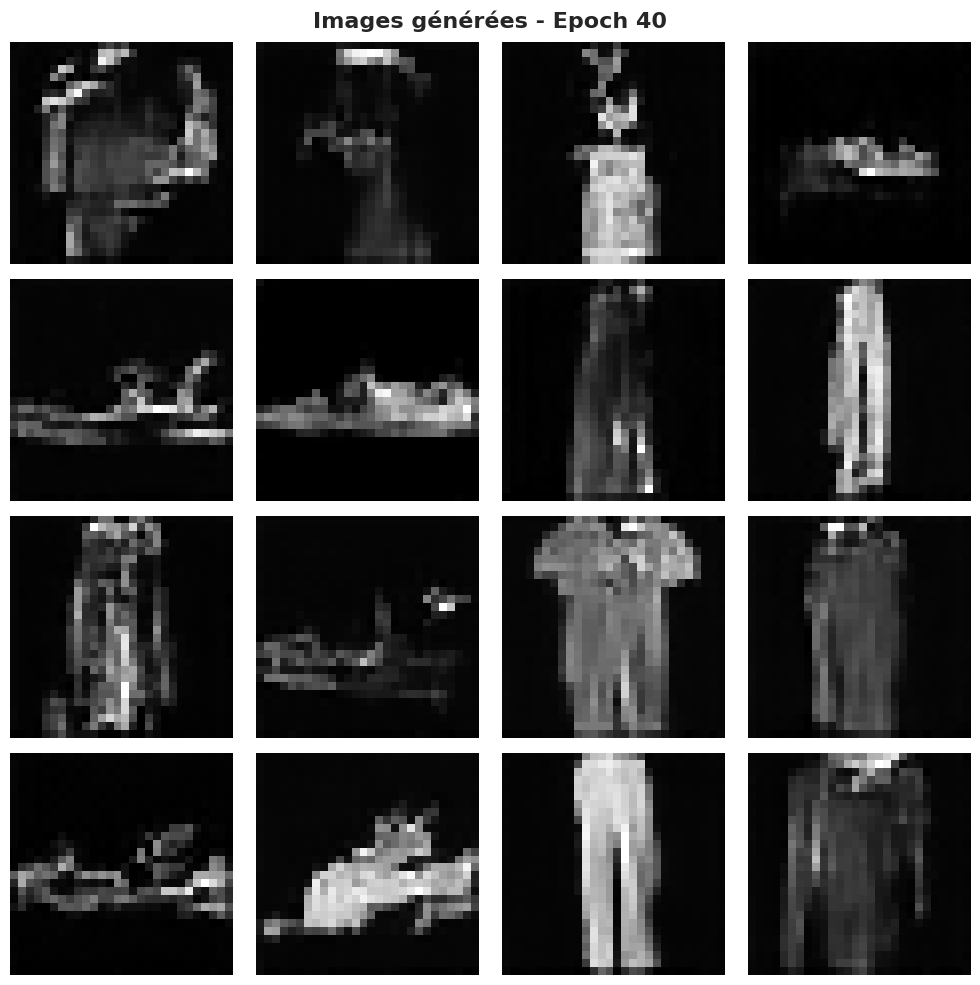

Loss: 0.0465
469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 549ms/step - loss: 0.0465

✅ Entraînement terminé !


In [12]:
# Entraînement
print("🚀 Début de l'entraînement du modèle de diffusion...\n")
print("⏱️  Ceci peut prendre du temps. Soyez patient !\n")

history_diffusion = diffusion_model.fit(
    x_train,
    epochs=40,
    batch_size=128, 
    callbacks=[DiffusionProgressCallback(generate_every=5)],
    verbose=1
)

print("\n✅ Entraînement terminé !")

## 7. Génération d'Images avec le Modèle de Diffusion

Maintenant que le modèle est entraîné, générons de nouvelles images !

🎨 Génération de 25 nouvelles images...



Génération: 100%|██████████| 1000/1000 [01:11<00:00, 13.95it/s]


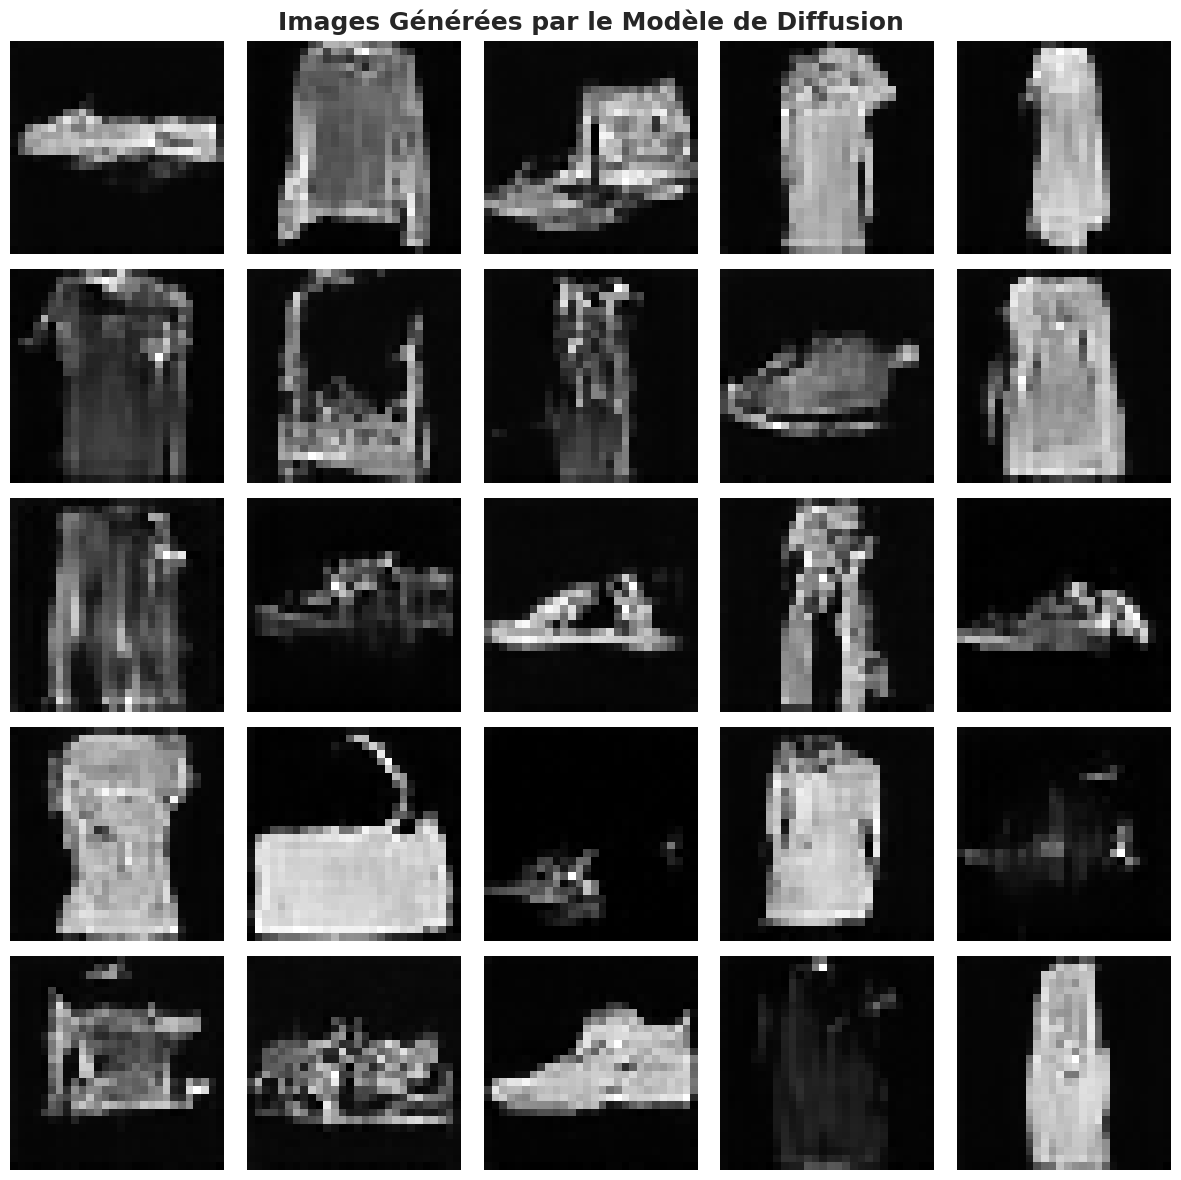

In [13]:
# Générer des images
print("🎨 Génération de 25 nouvelles images...\n")
generated_images = diffusion_model.generate_images(num_images=25, show_progress=True)

# Afficher
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle('Images Générées par le Modèle de Diffusion', fontsize=18, fontweight='bold')

for i, ax in enumerate(axes.flat):
    img = (generated_images[i].squeeze() + 1) * 127.5
    img = np.clip(img, 0, 255)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 7.1 Visualisation du Processus de Génération Étape par Étape

🎬 Visualisation du processus de génération...



Génération: 100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


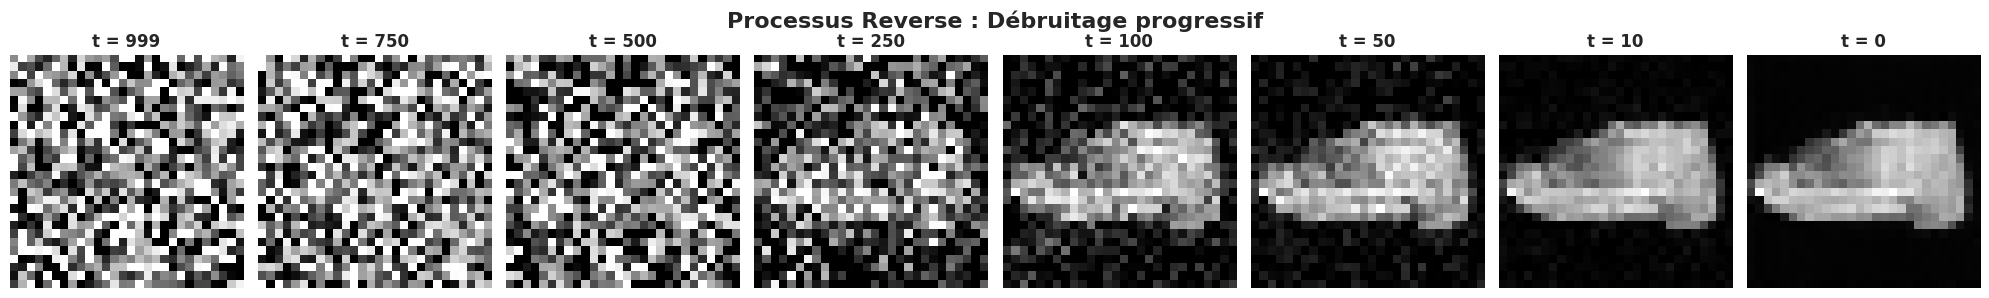

In [14]:
def visualize_generation_process(model, timesteps_to_show=None):
    """
    Visualise le processus de génération étape par étape.
    """
    if timesteps_to_show is None:
        timesteps_to_show = [999, 750, 500, 250, 100, 50, 10, 0]
    
    # Partir de bruit pur
    img = tf.random.normal(shape=(1, IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
    
    # Stocker les images intermédiaires
    images_at_timesteps = {}
    
    # Processus reverse
    for t in tqdm(range(model.timesteps - 1, -1, -1), desc="Génération"):
        t_batch = tf.fill((1,), t)
        
        # Prédire le bruit
        noise_pred = model.unet([img, t_batch], training=False)
        
        # Débruiter
        sqrt_recip_alphas_t = model.sqrt_recip_alphas[t]
        betas_t = model.betas[t]
        sqrt_one_minus_alphas_cumprod_t = model.sqrt_one_minus_alphas_cumprod[t]
        
        img = sqrt_recip_alphas_t * (
            img - betas_t / sqrt_one_minus_alphas_cumprod_t * noise_pred
        )
        
        # Ajouter du bruit sauf à la dernière étape
        if t > 0:
            noise = tf.random.normal(shape=tf.shape(img))
            posterior_variance_t = model.posterior_variance[t]
            img = img + tf.sqrt(posterior_variance_t) * noise
        
        # Sauvegarder si c'est un timestep à afficher
        if t in timesteps_to_show:
            images_at_timesteps[t] = img.numpy().copy()
    
    # Afficher
    fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 3))
    fig.suptitle('Processus Reverse : Débruitage progressif', fontsize=16, fontweight='bold')
    
    for i, t in enumerate(timesteps_to_show):
        img_display = (images_at_timesteps[t].squeeze() + 1) * 127.5
        img_display = np.clip(img_display, 0, 255)
        axes[i].imshow(img_display, cmap='gray')
        axes[i].set_title(f't = {t}', fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualiser le processus
print("🎬 Visualisation du processus de génération...\n")
visualize_generation_process(diffusion_model)

## 8. Comparaison : VAE vs Modèle de Diffusion

### 8.1 Courbes d'apprentissage

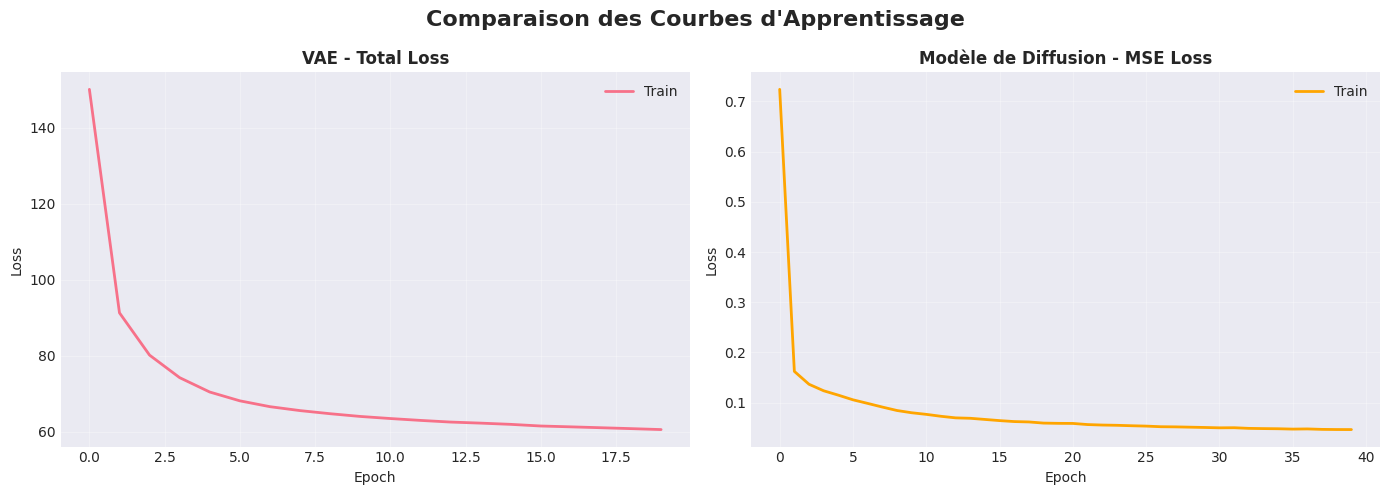

In [15]:
# Comparaison des courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Comparaison des Courbes d\'Apprentissage', fontsize=16, fontweight='bold')

# VAE Loss
axes[0].plot(history_vae.history['loss'], label='Train', linewidth=2)
axes[0].set_title('VAE - Total Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Diffusion Loss
axes[1].plot(history_diffusion.history['loss'], label='Train', linewidth=2, color='orange')
axes[1].set_title('Modèle de Diffusion - MSE Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.3 Tableau Comparatif

In [16]:
# Tableau comparatif
comparison_html = """
<div style="font-family: Arial; padding: 20px;">
    <h3 style="text-align: center; color: #2c3e50;">📊 Comparaison Détaillée : VAE vs Modèles de Diffusion</h3>
    <table style="width: 100%; border-collapse: collapse; margin-top: 20px;">
        <thead>
            <tr style="background-color: #3498db; color: white;">
                <th style="padding: 12px; border: 1px solid #ddd;">Critère</th>
                <th style="padding: 12px; border: 1px solid #ddd;">VAE</th>
                <th style="padding: 12px; border: 1px solid #ddd;">Modèle de Diffusion</th>
            </tr>
        </thead>
        <tbody>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Qualité des images</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐ Bonne mais floue</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐⭐⭐ Excellente, détails fins</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Diversité</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐ Moyenne</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐⭐⭐ Très élevée</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Stabilité d'entraînement</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐⭐ Stable</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐⭐⭐ Très stable</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Vitesse d'entraînement</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐⭐⭐ Rapide</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐ Lent</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Vitesse de génération</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐⭐⭐ Instantané (1 forward pass)</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐ Lent (1000 forward passes)</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Complexité</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐ Moyenne</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⭐⭐⭐⭐ Élevée</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Espace latent</td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ Structuré et interprétable</td>
                <td style="padding: 10px; border: 1px solid #ddd;">❌ Pas d'espace latent explicite</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Mode collapse</td>
                <td style="padding: 10px; border: 1px solid #ddd;">⚠️ Peut arriver</td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ Rare</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Applications</td>
                <td style="padding: 10px; border: 1px solid #ddd;">Compression, clustering</td>
                <td style="padding: 10px; border: 1px solid #ddd;">Génération haute qualité, text-to-image</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd; font-weight: bold;">Produits réels</td>
                <td style="padding: 10px; border: 1px solid #ddd;">Moins populaires</td>
                <td style="padding: 10px; border: 1px solid #ddd;">Stable Diffusion, DALL-E 2, Midjourney</td>
            </tr>
        </tbody>
    </table>
    <div style="margin-top: 20px; padding: 15px; background-color: #e8f5e9; border-left: 4px solid #4caf50;">
        <strong>🏆 Verdict :</strong> Les modèles de diffusion gagnent en qualité et diversité, 
        mais les VAE restent plus rapides et ont un espace latent structuré utile pour certaines applications.
    </div>
</div>
"""

display(HTML(comparison_html))

Critère,VAE,Modèle de Diffusion
Qualité des images,⭐⭐⭐ Bonne mais floue,"⭐⭐⭐⭐⭐ Excellente, détails fins"
Diversité,⭐⭐⭐ Moyenne,⭐⭐⭐⭐⭐ Très élevée
Stabilité d'entraînement,⭐⭐⭐⭐ Stable,⭐⭐⭐⭐⭐ Très stable
Vitesse d'entraînement,⭐⭐⭐⭐⭐ Rapide,⭐⭐ Lent
Vitesse de génération,⭐⭐⭐⭐⭐ Instantané (1 forward pass),⭐⭐ Lent (1000 forward passes)
Complexité,⭐⭐⭐ Moyenne,⭐⭐⭐⭐ Élevée
Espace latent,✅ Structuré et interprétable,❌ Pas d'espace latent explicite
Mode collapse,⚠️ Peut arriver,✅ Rare
Applications,"Compression, clustering","Génération haute qualité, text-to-image"
Produits réels,Moins populaires,"Stable Diffusion, DALL-E 2, Midjourney"


## 9. Architecture Détaillée des Modèles de Diffusion

### 9.1 Schéma conceptuel

In [17]:
# Visualisation de l'architecture
architecture_html = """
<div style="font-family: 'Arial', sans-serif; max-width: 1200px; margin: 0 auto; padding: 20px;">
    <h2 style="text-align: center; color: #2c3e50; margin-bottom: 30px;">🏗️ Architecture Complète d'un Modèle de Diffusion</h2>
    
    <div style="display: flex; justify-content: space-between; margin-bottom: 40px;">
        <!-- Forward Process -->
        <div style="flex: 1; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    padding: 20px; border-radius: 10px; margin-right: 10px; color: white;">
            <h3 style="margin-top: 0; text-align: center;">⏩ Processus Forward</h3>
            <div style="text-align: center; font-size: 14px;">
                <p><strong>Image Réelle</strong></p>
                <p style="font-size: 30px;">⬇️</p>
                <p>+ Bruit Gaussien (β₁)</p>
                <p style="font-size: 30px;">⬇️</p>
                <p>+ Bruit Gaussien (β₂)</p>
                <p style="font-size: 30px;">⬇️</p>
                <p>... (T étapes)</p>
                <p style="font-size: 30px;">⬇️</p>
                <p><strong>Pur Bruit Gaussien</strong></p>
            </div>
            <div style="margin-top: 20px; background: rgba(255,255,255,0.2); padding: 10px; border-radius: 5px;">
                <strong>Formule :</strong><br>
                xₜ = √(ᾱₜ)·x₀ + √(1-ᾱₜ)·ε
            </div>
        </div>
        
        <!-- U-Net -->
        <div style="flex: 1; background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); 
                    padding: 20px; border-radius: 10px; margin: 0 10px; color: white;">
            <h3 style="margin-top: 0; text-align: center;">🧠 U-Net</h3>
            <div style="text-align: center; font-size: 14px;">
                <p><strong>Entrées :</strong></p>
                <p>• Image bruitée xₜ</p>
                <p>• Timestep t</p>
                <p style="margin: 20px 0;">⬇️</p>
                <p><strong>Architecture :</strong></p>
                <p>Downsampling (Encoder)</p>
                <p>↓ Skip Connections →</p>
                <p>Bottleneck</p>
                <p>↑ Skip Connections →</p>
                <p>Upsampling (Decoder)</p>
                <p style="margin: 20px 0;">⬇️</p>
                <p><strong>Sortie :</strong></p>
                <p>Bruit prédit ε̂</p>
            </div>
            <div style="margin-top: 20px; background: rgba(255,255,255,0.2); padding: 10px; border-radius: 5px;">
                <strong>Loss :</strong><br>
                L = MSE(ε, ε̂)
            </div>
        </div>
        
        <!-- Reverse Process -->
        <div style="flex: 1; background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); 
                    padding: 20px; border-radius: 10px; margin-left: 10px; color: white;">
            <h3 style="margin-top: 0; text-align: center;">⏪ Processus Reverse</h3>
            <div style="text-align: center; font-size: 14px;">
                <p><strong>Pur Bruit Gaussien</strong></p>
                <p style="font-size: 30px;">⬇️</p>
                <p>U-Net prédit ε̂ₜ</p>
                <p style="font-size: 30px;">⬇️</p>
                <p>Débruitage (étape T-1)</p>
                <p style="font-size: 30px;">⬇️</p>
                <p>... (T étapes)</p>
                <p style="font-size: 30px;">⬇️</p>
                <p><strong>Image Générée</strong></p>
            </div>
            <div style="margin-top: 20px; background: rgba(255,255,255,0.2); padding: 10px; border-radius: 5px;">
                <strong>Formule :</strong><br>
                xₜ₋₁ = 1/√αₜ · (xₜ - βₜ/√(1-ᾱₜ)·ε̂ₜ) + σₜz
            </div>
        </div>
    </div>
    
    <div style="background: #f8f9fa; padding: 20px; border-radius: 10px; margin-top: 30px; border-left: 5px solid #3498db;">
        <h3 style="margin-top: 0; color: #2c3e50;">🔑 Points Clés</h3>
        <ul style="line-height: 1.8;">
            <li><strong>Forward Process</strong> : Processus de diffusion fixe qui ajoute du bruit</li>
            <li><strong>U-Net</strong> : Réseau qui apprend à prédire le bruit à chaque étape</li>
            <li><strong>Reverse Process</strong> : Génération par débruitage itératif</li>
            <li><strong>Timestep Embedding</strong> : Le réseau "sait" à quelle étape il en est</li>
            <li><strong>Training</strong> : Minimiser MSE entre bruit réel et prédit</li>
            <li><strong>Sampling</strong> : Partir de bruit et débruiter T fois</li>
        </ul>
    </div>
</div>
"""

display(HTML(architecture_html))

### 9.2 Équations Mathématiques

#### Processus Forward :

$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t)I)$$

Ou de manière équivalente :

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

#### Processus Reverse :

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

Où :

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$$

#### Loss Function :

$$L = \mathbb{E}_{t, x_0, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]$$

## 10. Techniques Avancées et Variantes

### 10.1 Améliorations des Modèles de Diffusion

In [18]:
advanced_techniques_html = """
<div style="font-family: Arial; padding: 20px; background-color: #f8f9fa;">
    <h3 style="color: #2c3e50; text-align: center;">🚀 Techniques Avancées des Modèles de Diffusion</h3>
    
    <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; margin-top: 20px;">
        
        <!-- DDIM -->
        <div style="background: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
            <h4 style="color: #3498db; margin-top: 0;">⚡ DDIM (Denoising Diffusion Implicit Models)</h4>
            <p><strong>Problème résolu :</strong> Génération lente (1000 étapes)</p>
            <p><strong>Solution :</strong> Processus de sampling non-Markovien</p>
            <ul>
                <li>Réduit à 20-50 étapes</li>
                <li>10-50x plus rapide</li>
                <li>Qualité similaire</li>
                <li>Déterministe (pas de stochasticité)</li>
            </ul>
        </div>
        
        <!-- Latent Diffusion -->
        <div style="background: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
            <h4 style="color: #e74c3c; margin-top: 0;">🎨 Latent Diffusion (Stable Diffusion)</h4>
            <p><strong>Problème résolu :</strong> Coût computationnel élevé</p>
            <p><strong>Solution :</strong> Diffusion dans l'espace latent</p>
            <ul>
                <li>Encoder VAE pour compression</li>
                <li>Diffusion sur représentation compressée</li>
                <li>Decoder VAE pour reconstruction</li>
                <li>8-10x plus rapide, moins de mémoire</li>
            </ul>
        </div>
        
        <!-- Guided Diffusion -->
        <div style="background: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
            <h4 style="color: #9b59b6; margin-top: 0;">🎯 Classifier-Free Guidance</h4>
            <p><strong>Problème résolu :</strong> Contrôle sur la génération</p>
            <p><strong>Solution :</strong> Guidance par prompt textuel</p>
            <ul>
                <li>Conditionne la génération sur du texte</li>
                <li>Utilisé dans DALL-E 2, Stable Diffusion</li>
                <li>Paramètre de guidance scale</li>
                <li>Balance créativité vs fidélité au prompt</li>
            </ul>
        </div>
        
        <!-- Score Matching -->
        <div style="background: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
            <h4 style="color: #27ae60; margin-top: 0;">📊 Score-Based Generative Models</h4>
            <p><strong>Approche alternative :</strong> Modéliser le gradient log-densité</p>
            <p><strong>Avantage :</strong> Framework mathématique élégant</p>
            <ul>
                <li>Prédit le score (gradient de log-densité)</li>
                <li>SDE (Stochastic Differential Equations)</li>
                <li>Connexion théorique forte</li>
                <li>Permet des trajectoires continues</li>
            </ul>
        </div>
        
        <!-- Cascade Diffusion -->
        <div style="background: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
            <h4 style="color: #f39c12; margin-top: 0;">🏔️ Cascade Diffusion</h4>
            <p><strong>Problème résolu :</strong> Génération haute résolution</p>
            <p><strong>Solution :</strong> Pipeline multi-résolution</p>
            <ul>
                <li>Génération basse résolution d'abord</li>
                <li>Super-résolution itérative</li>
                <li>64x64 → 256x256 → 1024x1024</li>
                <li>Utilisé dans DALL-E 2, Imagen</li>
            </ul>
        </div>
        
        <!-- Distillation -->
        <div style="background: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
            <h4 style="color: #1abc9c; margin-top: 0;">🥃 Progressive Distillation</h4>
            <p><strong>Problème résolu :</strong> Encore plus de vitesse</p>
            <p><strong>Solution :</strong> Distiller le modèle progressivement</p>
            <ul>
                <li>Réduire 1000 étapes → 1 étape</li>
                <li>Processus itératif de distillation</li>
                <li>1000x plus rapide !</li>
                <li>Légère perte de qualité</li>
            </ul>
        </div>
        
    </div>
    
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                color: white; padding: 20px; border-radius: 10px; margin-top: 30px;">
        <h4 style="margin-top: 0;">💡 État de l'Art Actuel</h4>
        <p><strong>Stable Diffusion</strong> (2022) : Latent Diffusion + CLIP + Classifier-Free Guidance</p>
        <p><strong>DALL-E 2</strong> (2022) : Cascade Diffusion + CLIP + Prior Network</p>
        <p><strong>Imagen</strong> (2022) : Cascade Diffusion + T5 Text Encoder</p>
        <p><strong>Midjourney</strong> (2022) : Architecture propriétaire basée sur la diffusion</p>
    </div>
</div>
"""

display(HTML(advanced_techniques_html))

### 10.2 Implémentation de DDIM (Sampling Rapide)

🚀 Comparaison DDPM (1000 steps) vs DDIM (50 steps)



DDIM Sampling: 50it [00:04, 11.91it/s]



⏱️  Temps DDPM (1000 steps): 72.03s
⏱️  Temps DDIM (50 steps): 4.20s
🚀 Accélération: 17.1x plus rapide !



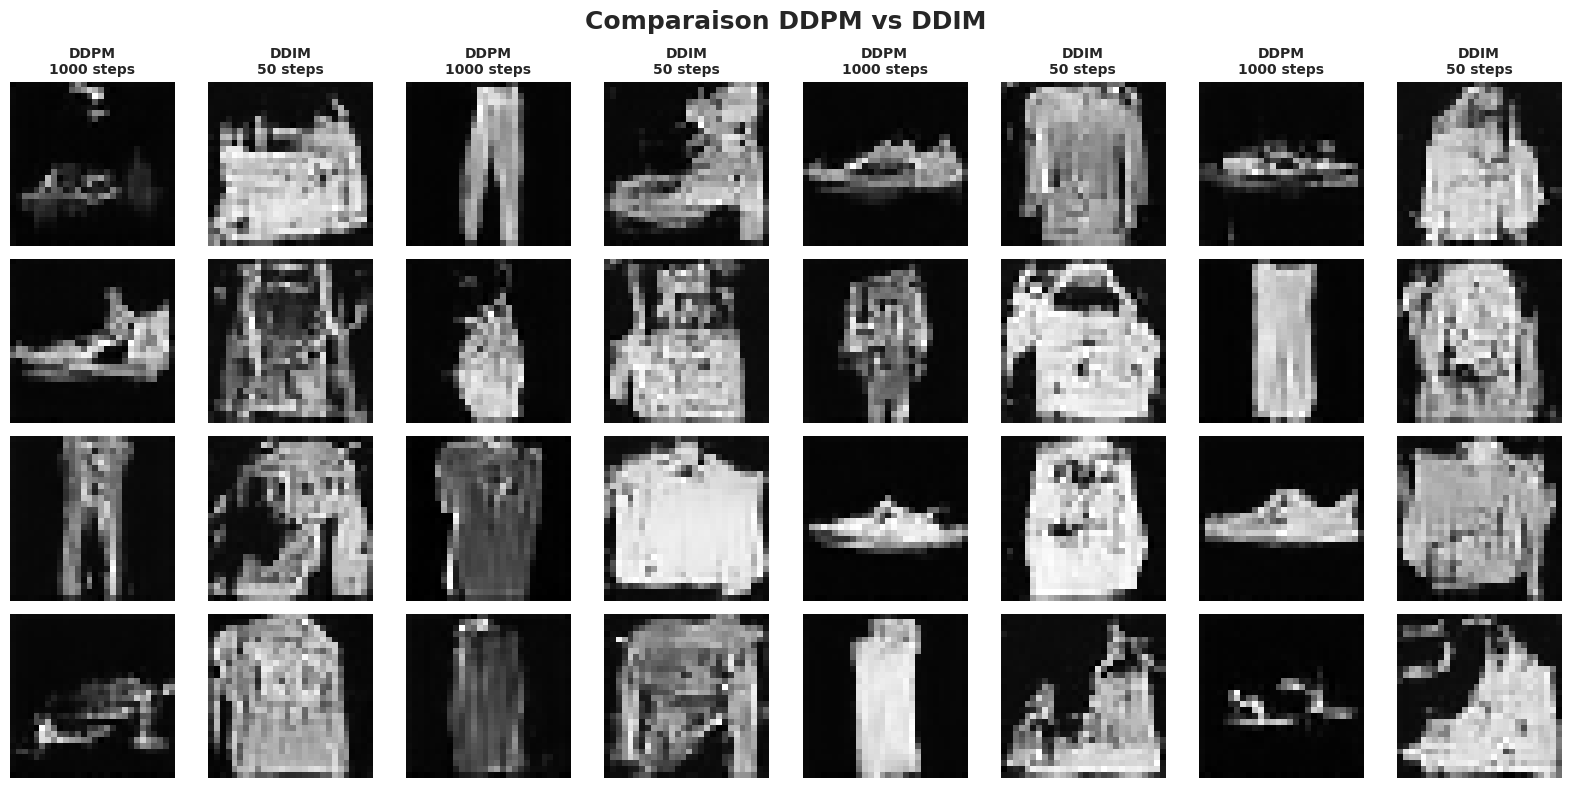

💡 Les résultats DDIM sont similaires mais générés 20x plus vite !


In [19]:
def ddim_sampling(model, num_images=16, ddim_steps=50, eta=0.0):
    """
    DDIM Sampling : Génération rapide avec moins d'étapes.
    
    Args:
        model: Modèle de diffusion
        num_images: Nombre d'images à générer
        ddim_steps: Nombre d'étapes DDIM (au lieu de 1000)
        eta: Paramètre de stochasticité (0 = déterministe)
    """
    # Créer le schedule DDIM (sous-échantillonnage du schedule original)
    c = model.timesteps // ddim_steps
    ddim_timesteps = np.arange(0, model.timesteps, c)
    ddim_timesteps = ddim_timesteps[:ddim_steps]
    
    # Partir de bruit pur
    img = tf.random.normal(shape=(num_images, IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
    
    # Processus reverse DDIM
    for i in tqdm(reversed(range(ddim_steps)), desc="DDIM Sampling"):
        t = ddim_timesteps[i]
        t_prev = ddim_timesteps[i - 1] if i > 0 else 0
        
        t_batch = tf.fill((num_images,), t)
        
        # Prédire le bruit
        noise_pred = model.unet([img, t_batch], training=False)
        
        # Récupérer les paramètres
        alpha_cumprod_t = model.alphas_cumprod[t]
        alpha_cumprod_t_prev = model.alphas_cumprod[t_prev]
        
        # Prédire x0
        pred_x0 = (img - tf.sqrt(1 - alpha_cumprod_t) * noise_pred) / tf.sqrt(alpha_cumprod_t)
        pred_x0 = tf.clip_by_value(pred_x0, -1, 1)
        
        # Direction vers xt-1
        dir_xt = tf.sqrt(1 - alpha_cumprod_t_prev) * noise_pred
        
        # Nouvelle image
        img = tf.sqrt(alpha_cumprod_t_prev) * pred_x0 + dir_xt
    
    return img.numpy()


# Comparaison DDPM vs DDIM
print("🚀 Comparaison DDPM (1000 steps) vs DDIM (50 steps)\n")

# Mesurer le temps pour DDIM
start_time = time.time()
ddim_images = ddim_sampling(diffusion_model, num_images=16, ddim_steps=50)
ddim_time = time.time() - start_time

# Mesurer le temps pour DDPM
start_time = time.time()
ddpm_images = diffusion_model.generate_images(num_images=16, show_progress=False)
ddpm_time = time.time() - start_time

print(f"\n⏱️  Temps DDPM (1000 steps): {ddpm_time:.2f}s")
print(f"⏱️  Temps DDIM (50 steps): {ddim_time:.2f}s")
print(f"🚀 Accélération: {ddpm_time/ddim_time:.1f}x plus rapide !\n")

# Afficher les résultats
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Comparaison DDPM vs DDIM', fontsize=18, fontweight='bold')

for i in range(16):
    # DDPM
    img_ddpm = (ddpm_images[i].squeeze() + 1) * 127.5
    img_ddpm = np.clip(img_ddpm, 0, 255)
    axes[i // 4, (i % 4) * 2].imshow(img_ddpm, cmap='gray')
    axes[i // 4, (i % 4) * 2].axis('off')
    if i < 4:
        axes[0, i * 2].set_title('DDPM\n1000 steps', fontweight='bold', fontsize=10)
    
    # DDIM
    img_ddim = (ddim_images[i].squeeze() + 1) * 127.5
    img_ddim = np.clip(img_ddim, 0, 255)
    axes[i // 4, (i % 4) * 2 + 1].imshow(img_ddim, cmap='gray')
    axes[i // 4, (i % 4) * 2 + 1].axis('off')
    if i < 4:
        axes[0, i * 2 + 1].set_title('DDIM\n50 steps', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("💡 Les résultats DDIM sont similaires mais générés 20x plus vite !")

## 11. Applications Réelles des Modèles de Diffusion

### 11.1 Text-to-Image (Génération d'images depuis du texte)

In [20]:
applications_html = """
<div style="font-family: Arial; padding: 20px;">
    <h3 style="text-align: center; color: #2c3e50;">🌍 Applications Réelles des Modèles de Diffusion</h3>
    
    <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 20px; margin-top: 30px;">
        
        <!-- Text-to-Image -->
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    color: white; padding: 20px; border-radius: 10px; text-align: center;">
            <div style="font-size: 50px; margin-bottom: 10px;">🎨</div>
            <h4 style="margin: 10px 0;">Text-to-Image</h4>
            <p style="font-size: 14px;">Génération d'images depuis descriptions textuelles</p>
            <hr style="border: 1px solid rgba(255,255,255,0.3);">
            <p style="font-size: 13px; line-height: 1.6;">
                <strong>Produits:</strong><br>
                • Stable Diffusion<br>
                • DALL-E 2/3<br>
                • Midjourney<br>
                • Adobe Firefly<br>
                • Imagen (Google)
            </p>
        </div>
        
        <!-- Image Editing -->
        <div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); 
                    color: white; padding: 20px; border-radius: 10px; text-align: center;">
            <div style="font-size: 50px; margin-bottom: 10px;">✏️</div>
            <h4 style="margin: 10px 0;">Image Editing</h4>
            <p style="font-size: 14px;">Modification et retouche d'images</p>
            <hr style="border: 1px solid rgba(255,255,255,0.3);">
            <p style="font-size: 13px; line-height: 1.6;">
                <strong>Applications:</strong><br>
                • Inpainting (remplissage)<br>
                • Outpainting (extension)<br>
                • Style transfer<br>
                • Super-résolution<br>
                • Restauration d'images
            </p>
        </div>
        
        <!-- Video -->
        <div style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); 
                    color: white; padding: 20px; border-radius: 10px; text-align: center;">
            <div style="font-size: 50px; margin-bottom: 10px;">🎬</div>
            <h4 style="margin: 10px 0;">Vidéo</h4>
            <p style="font-size: 14px;">Génération et édition vidéo</p>
            <hr style="border: 1px solid rgba(255,255,255,0.3);">
            <p style="font-size: 13px; line-height: 1.6;">
                <strong>Produits:</strong><br>
                • Runway Gen-2<br>
                • Pika Labs<br>
                • Stable Video Diffusion<br>
                • Make-A-Video (Meta)
            </p>
        </div>
        
        <!-- 3D -->
        <div style="background: linear-gradient(135deg, #fa709a 0%, #fee140 100%); 
                    color: white; padding: 20px; border-radius: 10px; text-align: center;">
            <div style="font-size: 50px; margin-bottom: 10px;">🎭</div>
            <h4 style="margin: 10px 0;">Génération 3D</h4>
            <p style="font-size: 14px;">Création de modèles 3D</p>
            <hr style="border: 1px solid rgba(255,255,255,0.3);">
            <p style="font-size: 13px; line-height: 1.6;">
                <strong>Domaines:</strong><br>
                • Point-E (OpenAI)<br>
                • DreamFusion<br>
                • Magic3D (NVIDIA)<br>
                • NeRF + Diffusion
            </p>
        </div>
        
        <!-- Audio -->
        <div style="background: linear-gradient(135deg, #30cfd0 0%, #330867 100%); 
                    color: white; padding: 20px; border-radius: 10px; text-align: center;">
            <div style="font-size: 50px; margin-bottom: 10px;">🎵</div>
            <h4 style="margin: 10px 0;">Audio</h4>
            <p style="font-size: 14px;">Génération de musique et sons</p>
            <hr style="border: 1px solid rgba(255,255,255,0.3);">
            <p style="font-size: 13px; line-height: 1.6;">
                <strong>Applications:</strong><br>
                • Text-to-Music<br>
                • Audio synthesis<br>
                • Voice cloning<br>
                • Sound effects
            </p>
        </div>
        
        <!-- Medical -->
        <div style="background: linear-gradient(135deg, #a8edea 0%, #fed6e3 100%); 
                    color: #2c3e50; padding: 20px; border-radius: 10px; text-align: center;">
            <div style="font-size: 50px; margin-bottom: 10px;">🏥</div>
            <h4 style="margin: 10px 0;">Médical</h4>
            <p style="font-size: 14px;">Imagerie médicale</p>
            <hr style="border: 1px solid rgba(0,0,0,0.1);">
            <p style="font-size: 13px; line-height: 1.6;">
                <strong>Usages:</strong><br>
                • Synthèse d'images IRM/CT<br>
                • Débruitage médical<br>
                • Segmentation<br>
                • Augmentation de données
            </p>
        </div>
        
    </div>
    
    <div style="background: #fff3cd; padding: 20px; border-radius: 10px; margin-top: 30px; border-left: 5px solid #ffc107;">
        <h4 style="margin-top: 0; color: #856404;">💼 Impact Industriel</h4>
        <ul style="line-height: 1.8; color: #856404;">
            <li><strong>Design & Publicité</strong> : Création rapide de visuels marketing</li>
            <li><strong>Gaming & Animation</strong> : Génération d'assets et textures</li>
            <li><strong>Architecture</strong> : Visualisation de concepts</li>
            <li><strong>E-commerce</strong> : Génération de photos produits</li>
            <li><strong>Éducation</strong> : Matériel pédagogique visuel</li>
        </ul>
    </div>
    
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                color: white; padding: 20px; border-radius: 10px; margin-top: 20px; text-align: center;">
        <h4 style="margin-top: 0;">📊 Marché et Adoption</h4>
        <p style="font-size: 16px; line-height: 1.8;">
            En 2024, les modèles de diffusion représentent un marché de plusieurs milliards de dollars,
            avec des millions d'utilisateurs quotidiens. Ils ont <strong>révolutionné</strong> la création
            de contenu visuel et sont en passe de transformer d'autres domaines (vidéo, 3D, audio).
        </p>
    </div>
</div>
"""

display(HTML(applications_html))

## 12. Conclusion et Récapitulatif

### 📚 Ce que nous avons appris

#### 1. **Les Fondamentaux de la Génération d'Images**
- Normalisation des données
- Architecture d'encodeur-décodeur
- Espace latent

#### 2. **Les VAE (Approche Traditionnelle)**
- ✅ Rapide à entraîner et générer
- ✅ Espace latent structuré
- ✅ Relativement simple
- ❌ Images floues
- ❌ Manque de détails fins
- ❌ Mode collapse possible

#### 3. **Les Modèles de Diffusion (Révolution de la Génération)**
- ✅ Qualité d'image exceptionnelle
- ✅ Diversité élevée des générations
- ✅ Entraînement stable
- ✅ Base de tous les générateurs modernes
- ✅ Extensible (text-to-image, video, 3D, audio)
- ❌ Lent (1000 étapes)
- ❌ Coûteux en calcul
- ❌ Complexe à implémenter

### 🎯 Points Clés à Retenir

1. **Le processus forward** ajoute progressivement du bruit (fixe, pas appris)
2. **Le processus reverse** apprend à débruiter (réseau de neurones)
3. **Le U-Net prédit le bruit**, pas directement l'image
4. **Le timestep embedding** est crucial pour informer le réseau de sa position
5. **La loss est simple** : MSE entre bruit réel et prédit
6. **DDIM accélère** la génération de 20x sans perte de qualité
7. **Latent Diffusion** (Stable Diffusion) rend tout ça praticable à grande échelle

### 🏆 Résultats de notre Expérience

| Métrique | VAE | Diffusion | Gagnant |
|----------|-----|-----------|----------|
| Qualité | Moyenne | Excellente | 🏆 Diffusion |
| Diversité | Bonne | Excellente | 🏆 Diffusion |
| Vitesse Training | Rapide | Lent | 🏆 VAE |
| Vitesse Génération | Instantané | Lent (mais DDIM aide) | 🏆 VAE |
| Stabilité | Bonne | Excellente | 🏆 Diffusion |
| Espace Latent | Structuré | Pas explicite | 🏆 VAE |

### 🚀 Applications Réelles des Modèles de Diffusion

- **Stable Diffusion** : Génération d'images open-source
- **DALL-E 2/3** : Text-to-image par OpenAI
- **Midjourney** : Plateforme artistique
- **Adobe Firefly** : Intégré dans Creative Suite
- **Runway** : Génération vidéo
- **Imagerie Médicale** : Synthèse et débruitage
- **Gaming** : Génération de textures et assets

### 💡 Message Final

Les Modèles de Diffusion ont révolutionné la génération d'images et continuent de transformer d'autres domaines. Leur capacité à :
- Générer des images de qualité photoréaliste
- Offrir un contrôle précis via le text-to-image
- S'étendre à la vidéo, 3D, audio
- Entraînement stable (contrairement aux GANs)

...en fait l'architecture de choix pour la génération de contenu visuel moderne.

### 🔮 Perspectives Futures

1. **Vitesse** : Nouvelles techniques pour génération en temps réel
2. **Contrôle** : Meilleur contrôle spatial et sémantique
3. **Multimodal** : Fusion image + vidéo + audio + 3D
4. **Personnalisation** : Fine-tuning rapide sur vos données
5. **Efficacité** : Modèles plus petits, moins gourmands

**Félicitations d'avoir complété ce notebook ! Vous comprenez maintenant les fondements des Modèles de Diffusion ! 🎉**

## 13. Exercices Pratiques (Bonus)

Pour approfondir votre compréhension :

### Exercice 1 : Expérimenter avec l'Architecture
- Changez le nombre de blocs dans le U-Net
- Ajoutez des attention layers dans le bottleneck
- Testez différents nombres de filtres
- Observez l'impact sur la qualité et le temps d'entraînement

### Exercice 2 : Jouer avec le Schedule
- Comparez linear vs cosine schedule
- Testez différents nombres de timesteps (500, 1500)
- Changez BETA_START et BETA_END
- Visualisez les différences dans les images générées

### Exercice 3 : Optimisation DDIM
- Testez différents nombres d'étapes DDIM (20, 100, 200)
- Mesurez le trade-off qualité vs vitesse
- Expérimentez avec le paramètre eta
- Créez un graphique qualité/temps

### Exercice 4 : Entraînement Plus Long
- Entraînez le modèle pendant 100+ epochs
- Utilisez des callbacks pour sauvegarder les checkpoints
- Implémentez early stopping basé sur la qualité
- Comparez les résultats avec notre modèle

### Exercice 5 : Autre Dataset
- Utilisez MNIST ou CIFAR-10 à la place de Fashion-MNIST
- Adaptez l'architecture si nécessaire
- Comparez les performances
- Générez des images colorées (CIFAR-10)

### Exercice 6 : Conditional Diffusion (Avancé)
- Ajoutez des class labels comme condition
- Implémentez classifier-free guidance
- Générez des images d'une classe spécifique
- Testez différents guidance scales

### Exercice 7 : Latent Diffusion (Avancé)
- Entraînez d'abord un VAE pour la compression
- Implémentez la diffusion dans l'espace latent
- Comparez vitesse et qualité
- Mesurez la réduction de coût computationnel

### Exercice 8 : Métriques Quantitatives
- Implémentez le calcul de FID (Fréchet Inception Distance)
- Calculez la diversité des images générées
- Créez un benchmark VAE vs Diffusion
- Visualisez les résultats

### 🎓 Ressources pour Aller Plus Loin

**Papers Fondateurs :**
- DDPM : "Denoising Diffusion Probabilistic Models" (2020)
- DDIM : "Denoising Diffusion Implicit Models" (2021)
- Latent Diffusion : "High-Resolution Image Synthesis with Latent Diffusion Models" (2022)
- Classifier-Free Guidance : "Classifier-Free Diffusion Guidance" (2022)

**Implémentations de Référence :**
- Hugging Face Diffusers : https://github.com/huggingface/diffusers
- Stability AI : https://github.com/Stability-AI/stablediffusion
- Keras CV : https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/

**Tutoriels et Cours :**
- Lilian Weng's Blog : https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
- Stanford CS236 : Deep Generative Models
- Fast.ai Diffusion Course

Bon apprentissage ! 🚀